In [1]:
import numpy as np

import sys
sys.path.append("/home/mayajas/Documents/programs/prfpy-main")

from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, DoG_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, DoG_Iso2DGaussianFitter

import os
from os.path import join as opj
import scipy.io

import nibabel as nib

import matplotlib.pyplot as plt

import nilearn
from nilearn import plotting, datasets, image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_roi

import pickle
import pandas as pd

import itertools

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures

import random

from scipy import stats

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from transformations import quaternion_from_matrix, euler_from_quaternion

import nipype.interfaces.fsl as fsl

# import glob
import math 

from scipy.spatial import KDTree


import numpy.matlib

import seaborn as sb

from scipy.stats import gaussian_kde



/home/mayajas/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/mayajas/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


230218-14:47:11,762 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


#### General directories and settings

In [2]:
subject_list = ['sub-01','sub-02','sub-03','sub-04']
hem_list     = ['lh','rh']
roi_list     = ['V1','V2','V3']
layer_space  = 'anat'
prf_model    = 'prfpy_Iso2DGaussianModel'
# prf_model    = 'prfpy_Iso2DGaussianModel_LinearDeveining'


proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/'+prf_model+'/'

report_dir   = '/home/mayajas/Documents/project-00-7t-pipeline-dev/reports/figures'

# dataframe outputs of pRF_getSigmaAcrossDepth.py
if layer_space == 'func':
    df_layers_fn = opj(prfpy_dir,'df_layers_allROI_func')
else:
    df_layers_fn = opj(prfpy_dir,'df_layers_allROI')


In [3]:
screen_size_cm     = 12.0
screen_distance_cm = 52.0
TR                 = 3.0
#design_matrix      = mat["stim"]

max_ecc = math.atan(screen_size_cm/screen_distance_cm)/2
max_ecc_deg = math.degrees(max_ecc)

print("Max eccentricity of stimulus is "+str(round(max_ecc_deg,2)))

Max eccentricity of stimulus is 6.5


Set number of layers, eccentricities, subjects, hemispheres, ROIs

In [4]:
rsq_thresh = 0.15
n_layers   = 6
n_sub      = len(subject_list)
n_hem      = len(hem_list)
n_rois     = 3


#### Useful functions

In [5]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)], abs(data - np.mean(data)) < m * np.std(data)

In [6]:
def reject_outliers_median(data, m=3.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m], s < m

In [7]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# PRF size across cortical depth: all subjects

## Load data

In [8]:
f = open(df_layers_fn,'rb')
df_equivol_per_depth, \
df_equivol_per_depth_ecc2, \
df_equidist_per_depth, \
df_equidist_per_depth_ecc2, \
df_pRF_per_cortdist, \
df_pRF_per_cortdist_ecc2 = pickle.load(f)

f.close()

In [9]:
df_equivol_per_depth.head()

sub id roi hem  depth                                           pRF size  \
0  sub-01  V1  lh    1.0  [0.4014067382530454, 0.4027635568549481, 0.411...   
1  sub-01  V1  lh    2.0  [0.5028093607754424, 1.3778713209473807, 0.372...   
2  sub-01  V1  lh    3.0  [0.4103991615151292, 1.0728341630828246, 1.362...   
3  sub-01  V1  lh    4.0  [0.40599301206943644, 0.41899280041739106, 0.8...   
4  sub-01  V1  lh    5.0  [1.0788782490087125, 0.38117418269899284, 1.05...   

                                                 ecc  \
0  [0.7476031117501816, 1.5603951275927541, 6.579...   
1  [0.6923324559450494, 6.591971021608676, 0.9251...   
2  [3.7162537566340603, 0.11823975963706833, 3.68...   
3  [0.9353106961724557, 2.1428380467067485, 2.651...   
4  [6.584247833210548, 1.8458181229896062, 1.1254...   

                                                 rsq  
0  [0.05905815473194287, 0.043080920543032364, 0....  
1  [0.24479332504722995, 0.12554899960429722, 0.0...  
2  [0.08515955901376882, 0.1495453861604299, 0.08...  
3  [0.33907941925853236, 0.07551410760443167, 0.0...  
4  [0.08574507358513117, 0.06165153178493121, 0.1...

In [10]:
df_equidist_per_depth.head()

sub id roi hem  depth                                           pRF size  \
0  sub-01  V1  lh    1.0  [0.41119937679885, 0.4110252350201856, 0.32644...   
1  sub-01  V1  lh    2.0  [1.3778713209473807, 0.39397682128063954, 0.50...   
2  sub-01  V1  lh    3.0  [1.0728341630828246, 0.7043548973343082, 0.502...   
3  sub-01  V1  lh    4.0  [0.40599301206943644, 0.41899280041739106, 0.7...   
4  sub-01  V1  lh    5.0  [0.38117418269899284, 1.0577542114928036, 0.59...   

                                                 ecc  \
0  [6.5795980027226895, 1.102146332632887, 0.8522...   
1  [6.591971021608676, 1.2091919486770515, 0.6493...   
2  [0.11823975963706833, 1.3347729689462977, 0.69...   
3  [0.9353106961724557, 2.1428380467067485, 0.834...   
4  [1.8458181229896062, 1.125413070594692, 6.5804...   

                                                 rsq  
0  [0.11943411775830015, 0.1333012821436964, 0.08...  
1  [0.12554899960429722, 0.08112256585909694, 0.1...  
2  [0.1495453861604299, 0.13558468553964953, 0.24...  
3  [0.33907941925853236, 0.07551410760443167, 0.1...  
4  [0.06165153178493121, 0.1414687348872291, 0.06...

In [11]:
df_pRF_per_cortdist.head()

sub id roi hem                                           pRF size  \
0  sub-01  V1  lh  [0.6995862165835947, 1.0788782490087125, 0.381...   
1  sub-01  V2  lh  [1.2195367062149134, 0.403460194562427, 0.8227...   
2  sub-01  V3  lh  [0.601084544240993, 1.3840549883832673, 0.4118...   
3  sub-01  V1  rh  [0.4111922485508004, 0.5954419581025879, 0.409...   
4  sub-01  V2  rh  [0.8245820868298239, 1.2283051204874245, 1.223...   

                                                 ecc  \
0  [1.3965025929669226, 6.584247833210548, 1.8458...   
1  [6.5804084761262605, 2.1432384223923617, 1.625...   
2  [5.795197146694691, 1.0081547473803154, 0.9695...   
3  [6.58667352631391, 1.6847943054930699, 2.62298...   
4  [0.8272515897144248, 2.1501640225712864, 6.582...   

                                                 rsq  \
0  [0.09367336613356936, 0.08574507358513117, 0.0...   
1  [0.10854078047264448, 0.06323345540758984, 0.0...   
2  [0.06684781733332179, 0.1966229873319677, 0.25...   
3  [0.06886632411105642, 0.08301480030843089, 0.1...   
4  [0.11428744693722115, 0.15193790572230692, 0.1...   

                                           cort dist  
0  [2.529822128134704, 2.2627416997969525, 2.2627...  
1  [2.2627416997969525, 2.2627416997969525, 2.400...  
2  [1.6, 1.6, 1.788854381999832, 0.8, 1.131370849...  
3  [-1.6, -1.6, -1.6, -1.1313708498984762, -1.385...  
4  [1.9595917942265424, 2.4000000000000004, 1.788...

In [12]:
df_pRF_per_cortdist_ecc2.head()

sub id roi hem                                           pRF size  \
0  sub-01  V1  lh  [0.6995862165835947, 1.0788782490087125, 0.381...   
1  sub-01  V2  lh  [1.2195367062149134, 0.8227160482385882, 0.411...   
2  sub-01  V3  lh  [1.3840549883832673, 0.4118978465600136, 0.937...   
3  sub-01  V1  rh  [0.4059388223182111, 0.9482074146532964, 0.411...   
4  sub-01  V2  rh  [0.5033425671926188, 0.501605011879007, 1.2269...   

                                                 ecc  \
0  [1.3965025929669226, 6.584247833210548, 1.8458...   
1  [6.5804084761262605, 1.6250280181019194, 6.580...   
2  [1.0081547473803154, 0.9695462588330056, 0.661...   
3  [2.125413388640813, 5.059917202026603, 6.58685...   
4  [0.2282230409813217, 0.4110093389866788, 0.381...   

                                                 rsq  \
0  [0.09367336613356936, 0.08574507358513117, 0.0...   
1  [0.10854078047264448, 0.09116691384733222, 0.0...   
2  [0.1966229873319677, 0.2588998310749342, 0.150...   
3  [0.07370363352955611, 0.14208801594737674, 0.0...   
4  [0.10792627386086495, 0.26305261722019635, 0.2...   

                                           cort dist  
0  [2.529822128134704, 2.2627416997969525, 2.2627...  
1  [2.2627416997969525, 2.4000000000000004, 1.959...  
2  [1.6, 1.788854381999832, 0.8, 1.13137084989847...  
3  [-0.8, -1.1313708498984762, -1.788854381999832...  
4  [1.1313708498984762, 1.788854381999832, 2.2627...

## Laynii layers: pRF per cortical layer fitted at target eccentricity

### Equidistant layering

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [13]:

target_ecc = 2
pRF_thresh = max_ecc_deg

In [14]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [15]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


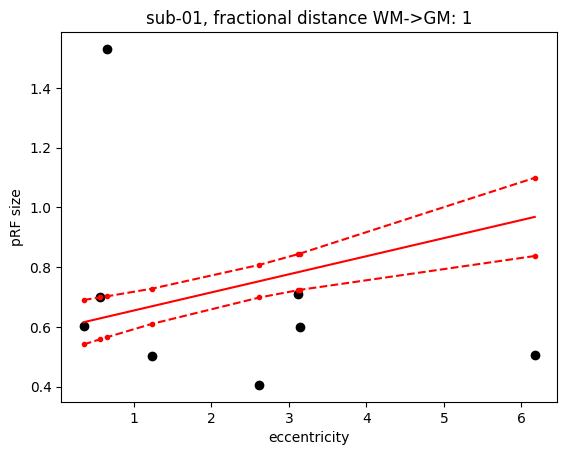

Intercept: 0.5941162281774418
t = 14.18, p = 0.00000
Slope: 0.060573104575399724
t = 4.01, p = 0.00006
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


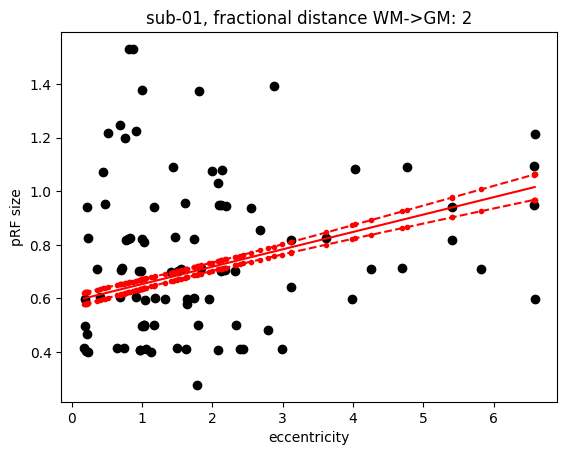

Intercept: 0.5887241934137744
t = 49.38, p = 0.00000
Slope: 0.0648558074606509
t = 13.45, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


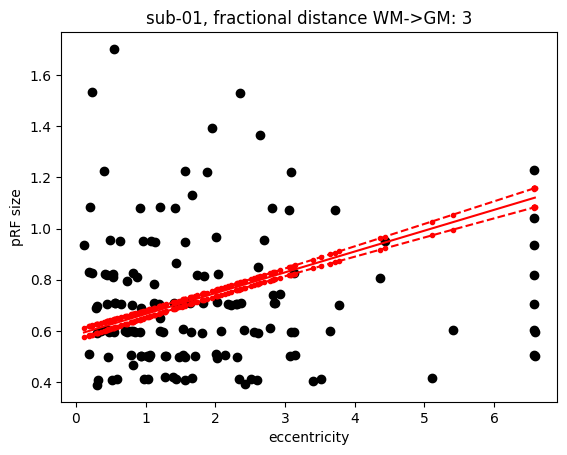

Intercept: 0.584543877100365
t = 59.84, p = 0.00000
Slope: 0.08136880926542975
t = 21.25, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


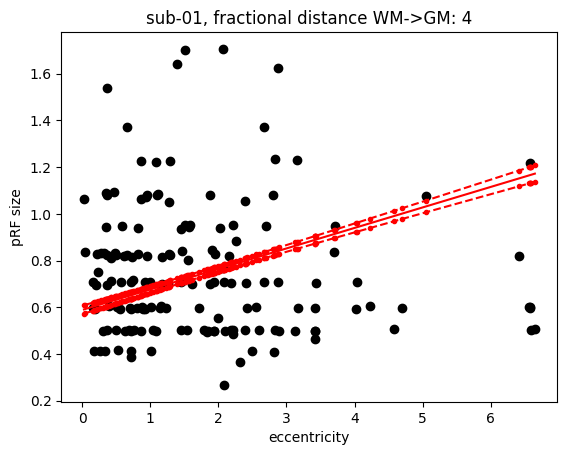

Intercept: 0.5887489432794566
t = 63.63, p = 0.00000
Slope: 0.08778256652467198
t = 24.55, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


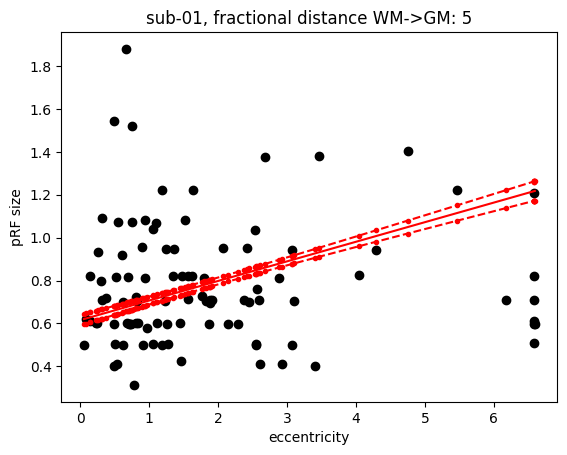

Intercept: 0.615301441482945
t = 49.52, p = 0.00000
Slope: 0.09133764081854176
t = 19.42, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


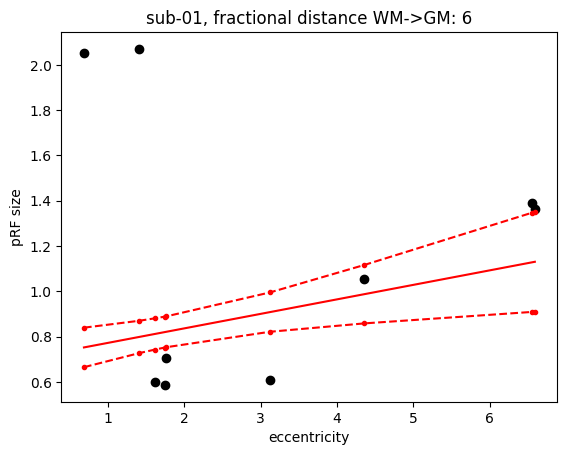

Intercept: 0.708410194730482
t = 12.70, p = 0.00000
Slope: 0.0640782258877957
t = 2.80, p = 0.00514
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


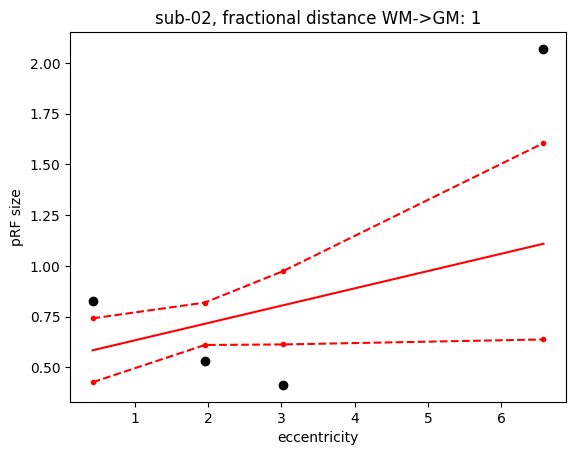

Intercept: 0.5471188496424204
t = 5.59, p = 0.00000
Slope: 0.08543027470368417
t = 1.69, p = 0.09016
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


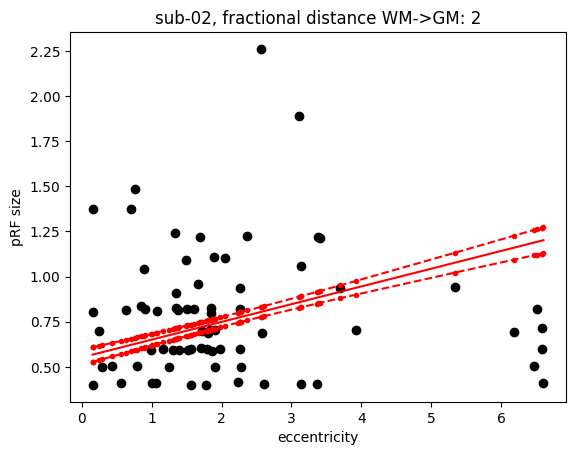

Intercept: 0.5521802176913848
t = 25.49, p = 0.00000
Slope: 0.09834853932342005
t = 12.80, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


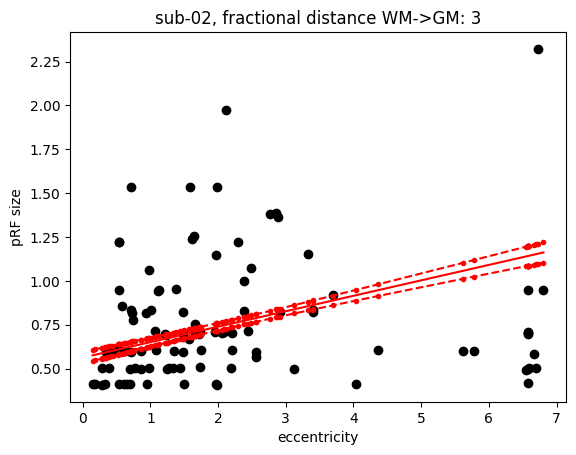

Intercept: 0.5628998488498793
t = 33.22, p = 0.00000
Slope: 0.08803547887524257
t = 14.71, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


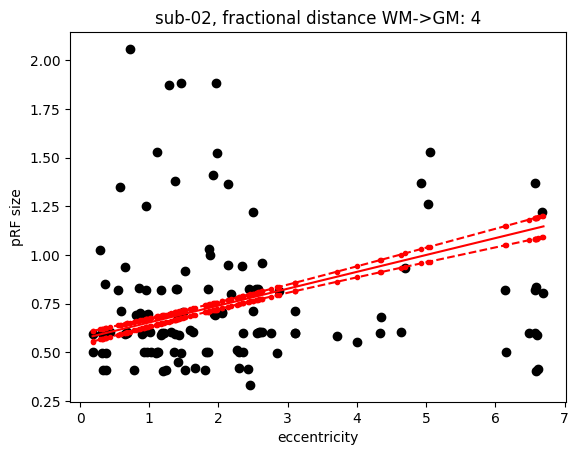

Intercept: 0.5660529863577592
t = 38.63, p = 0.00000
Slope: 0.08667534691665857
t = 15.25, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


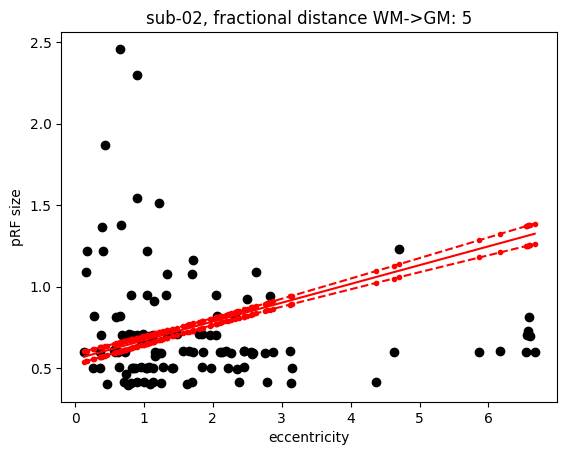

Intercept: 0.5547344020248257
t = 32.10, p = 0.00000
Slope: 0.11533839456205121
t = 17.60, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


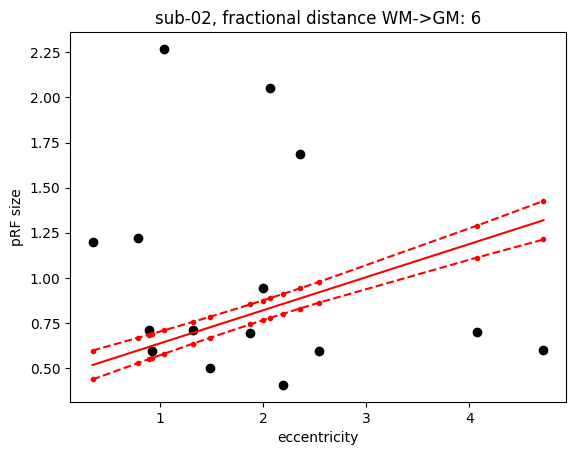

Intercept: 0.4524543728194397
t = 9.93, p = 0.00000
Slope: 0.1837938975108039
t = 10.49, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


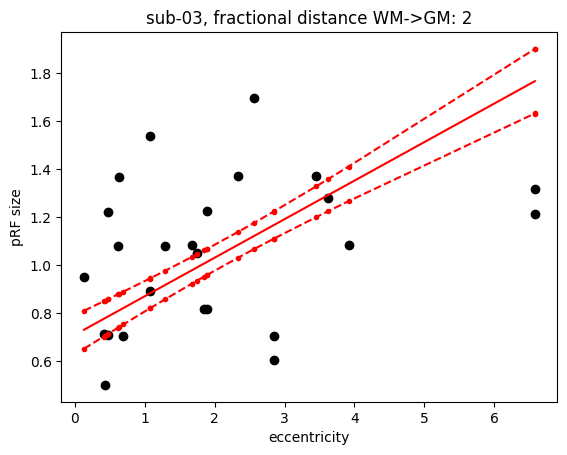

Intercept: 0.7087211401524596
t = 16.95, p = 0.00000
Slope: 0.16077079918241913
t = 11.19, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


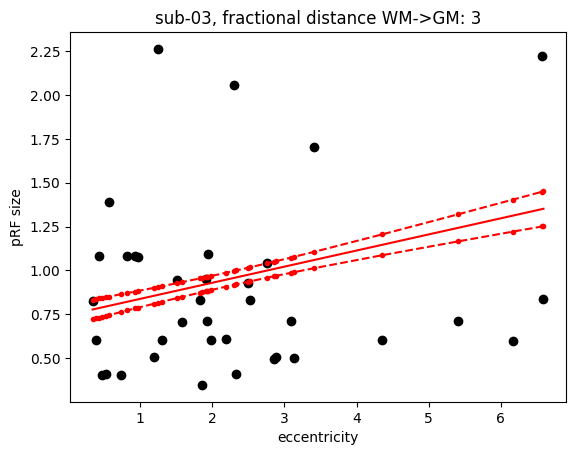

Intercept: 0.7465855098972793
t = 23.82, p = 0.00000
Slope: 0.09170592778165157
t = 8.59, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


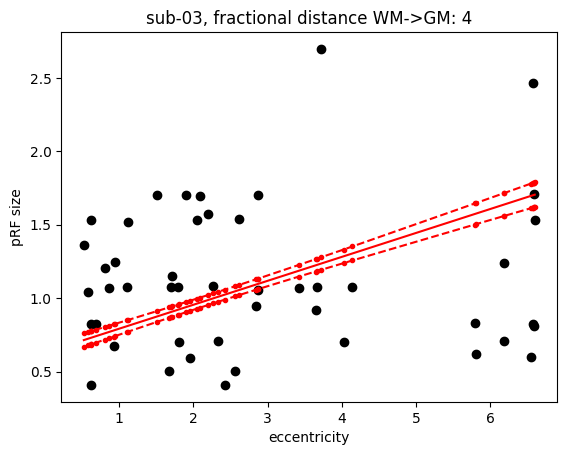

Intercept: 0.6289404166871815
t = 23.20, p = 0.00000
Slope: 0.1631350944389211
t = 17.81, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


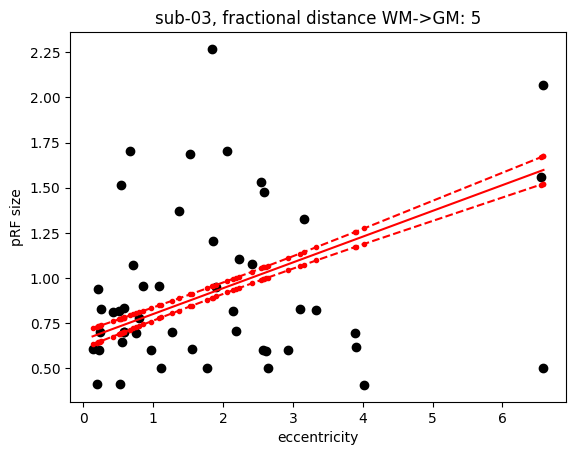

Intercept: 0.6581962940326546
t = 27.85, p = 0.00000
Slope: 0.14272602199148401
t = 17.88, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


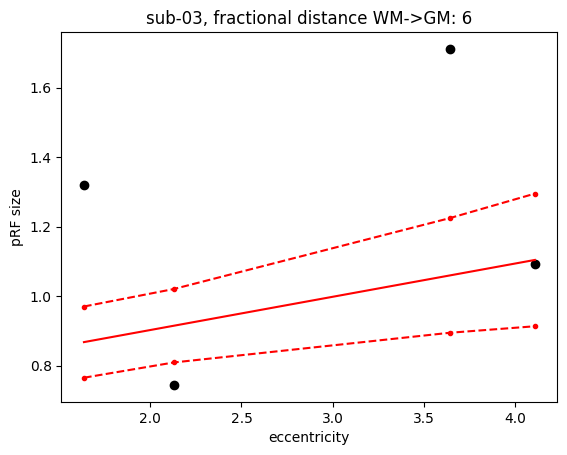

Intercept: 0.7118858697575492
t = 8.96, p = 0.00000
Slope: 0.09547737892549213
t = 2.76, p = 0.00578
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


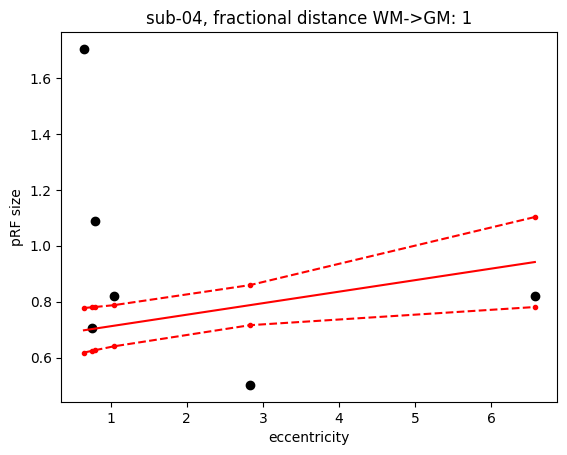

Intercept: 0.6708925045572632
t = 14.16, p = 0.00000
Slope: 0.041204989818253615
t = 2.52, p = 0.01188
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


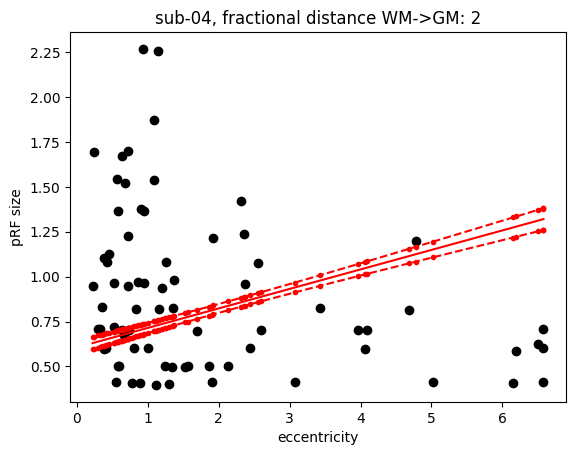

Intercept: 0.6057068549264044
t = 32.83, p = 0.00000
Slope: 0.10860280689172386
t = 17.12, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


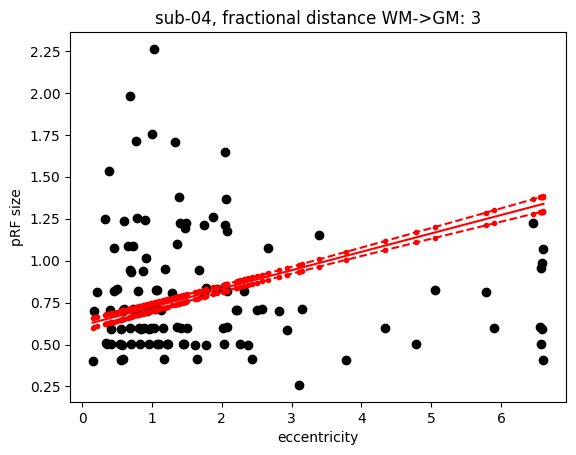

Intercept: 0.6136774638236899
t = 40.30, p = 0.00000
Slope: 0.10970975335803465
t = 22.67, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


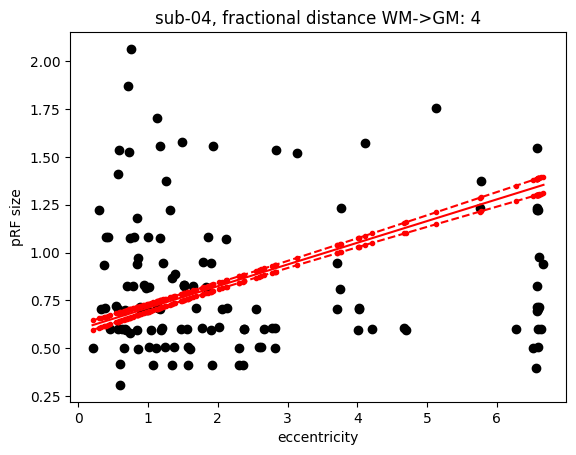

Intercept: 0.5969578307876076
t = 44.28, p = 0.00000
Slope: 0.11349101264796124
t = 24.70, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


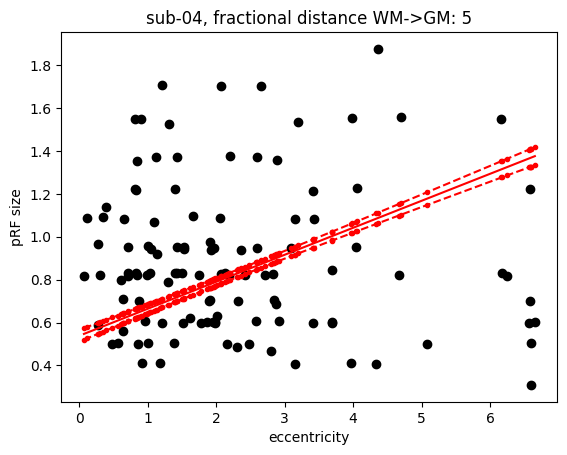

Intercept: 0.5382642936235542
t = 38.60, p = 0.00000
Slope: 0.12587030514833555
t = 27.42, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


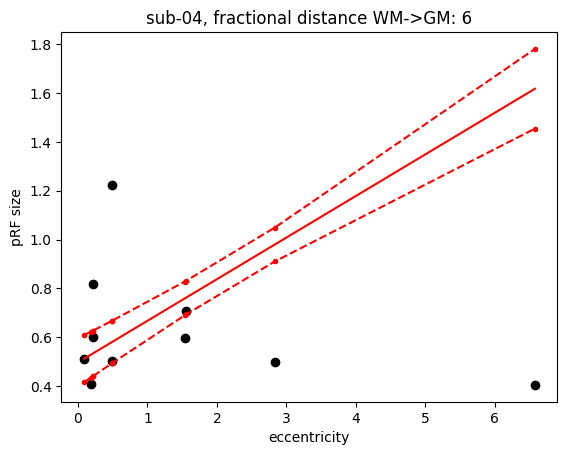

Intercept: 0.49753106688907245
t = 9.90, p = 0.00000
Slope: 0.1702269085905717
t = 9.85, p = 0.00000


In [16]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['roi'] == 'V1') & 
                                    (df_equidist_per_depth['hem'] == 'lh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth['roi'] == 'V1') & 
                                    (df_equidist_per_depth['hem'] == 'rh') & 
                                    (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equidist.loc[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equidist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        df_pRFxecc_stats_equidist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])

        df_pRFxecc_stats_equidist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist.index[idx])
        
    

TODO: eccentricity bins and take avg pRF size in each bin, compute linear regression to these points, bootstrapping

In [17]:
df_pRFxecc_stats_equidist


sub id  depth     intercept         slope         intercept-stats  \
0   sub-01    1.0  5.941162e-01  6.057310e-02  t = 14.18, p = 0.00000   
1   sub-01    2.0  5.887242e-01  6.485581e-02  t = 49.38, p = 0.00000   
2   sub-01    3.0  5.845439e-01  8.136881e-02  t = 59.84, p = 0.00000   
3   sub-01    4.0  5.887489e-01  8.778257e-02  t = 63.63, p = 0.00000   
4   sub-01    5.0  6.153014e-01  9.133764e-02  t = 49.52, p = 0.00000   
5   sub-01    6.0  7.084102e-01  6.407823e-02  t = 12.70, p = 0.00000   
6   sub-02    1.0  5.471188e-01  8.543027e-02   t = 5.59, p = 0.00000   
7   sub-02    2.0  5.521802e-01  9.834854e-02  t = 25.49, p = 0.00000   
8   sub-02    3.0  5.628998e-01  8.803548e-02  t = 33.22, p = 0.00000   
9   sub-02    4.0  5.660530e-01  8.667535e-02  t = 38.63, p = 0.00000   
10  sub-02    5.0  5.547344e-01  1.153384e-01  t = 32.10, p = 0.00000   
11  sub-02    6.0  4.524544e-01  1.837939e-01   t = 9.93, p = 0.00000   
12  sub-03    1.0  2.831824e-56  2.831824e-56                     0.0   
13  sub-03    2.0  7.087211e-01  1.607708e-01  t = 16.95, p = 0.00000   
14  sub-03    3.0  7.465855e-01  9.170593e-02  t = 23.82, p = 0.00000   
15  sub-03    4.0  6.289404e-01  1.631351e-01  t = 23.20, p = 0.00000   
16  sub-03    5.0  6.581963e-01  1.427260e-01  t = 27.85, p = 0.00000   
17  sub-03    6.0  7.118859e-01  9.547738e-02   t = 8.96, p = 0.00000   
18  sub-04    1.0  6.708925e-01  4.120499e-02  t = 14.16, p = 0.00000   
19  sub-04    2.0  6.057069e-01  1.086028e-01  t = 32.83, p = 0.00000   
20  sub-04    3.0  6.136775e-01  1.097098e-01  t = 40.30, p = 0.00000   
21  sub-04    4.0  5.969578e-01  1.134910e-01  t = 44.28, p = 0.00000   
22  sub-04    5.0  5.382643e-01  1.258703e-01  t = 38.60, p = 0.00000   
23  sub-04    6.0  4.975311e-01  1.702269e-01   t = 9.90, p = 0.00000   

               slope-stats  pRF@2deg  
0    t = 4.01, p = 0.00006  0.715262  
1   t = 13.45, p = 0.00000  0.718436  
2   t = 21.25, p = 0.00000  0.747281  
3   t = 24.55, p = 0.00000  0.764314  
4   t = 19.42, p = 0.00000  0.797977  
5    t = 2.80, p = 0.00514  0.836567  
6    t = 1.69, p = 0.09016  0.717979  
7   t = 12.80, p = 0.00000  0.748877  
8   t = 14.71, p = 0.00000  0.738971  
9   t = 15.25, p = 0.00000  0.739404  
10  t = 17.60, p = 0.00000  0.785411  
11  t = 10.49, p = 0.00000  0.820042  
12                     0.0       NaN  
13  t = 11.19, p = 0.00000  1.030263  
14   t = 8.59, p = 0.00000  0.929997  
15  t = 17.81, p = 0.00000  0.955211  
16  t = 17.88, p = 0.00000  0.943648  
17   t = 2.76, p = 0.00578  0.902841  
18   t = 2.52, p = 0.01188  0.753302  
19  t = 17.12, p = 0.00000  0.822912  
20  t = 22.67, p = 0.00000  0.833097  
21  t = 24.70, p = 0.00000  0.823940  
22  t = 27.42, p = 0.00000  0.790005  
23   t = 9.85, p = 0.00000  0.837985

#### Plot estimated pRF size at target eccentricity

[3.50626071e-03 8.97856138e-05 7.09813661e-01]
R2 quadratic: 0.9936968278862403
R2 linear: 0.952527978676381
[ 0.00432717 -0.01256593  0.73679948]
R2 quadratic: 0.886221523419478
R2 linear: 0.786246874328814
[ 0.00586713 -0.07105636  1.13100905]
R2 quadratic: 0.6918473169238979
R2 linear: 0.6389182283766
[-0.00508264  0.04459369  0.73121574]
R2 quadratic: 0.4510224434330764
R2 linear: 0.2687716034840053


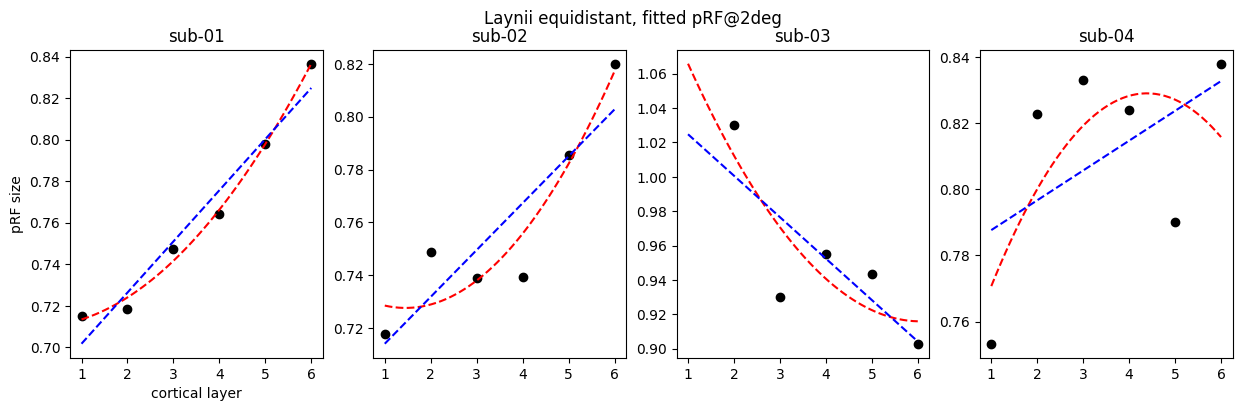

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
#     axs[sub_id].set_ylim([0.65, 0.95])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.95,4)) 
    
plt.suptitle('Laynii equidistant, fitted pRF@2deg')
plt.show()
    
#     axs[sub_id].set_ylim([0.7, 1.1]4
#     axs[sub_id].set_yticks(np.linspace(0.7,1.1,5))    
    
#     df_pRFxecc_stats_equidist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

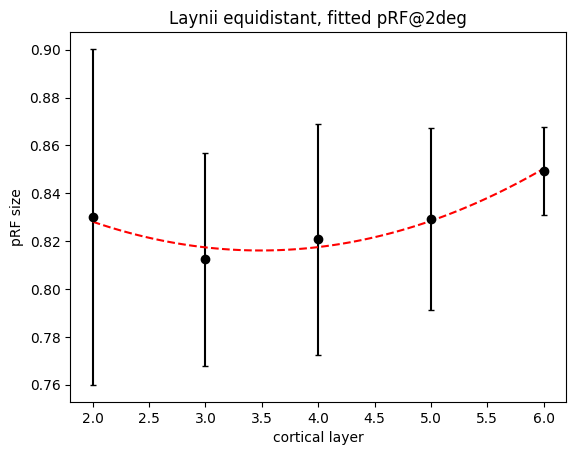

In [19]:
idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist[(df_pRFxecc_stats_equidist['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equidist['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equidistant, fitted pRF@2deg')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [20]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [21]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


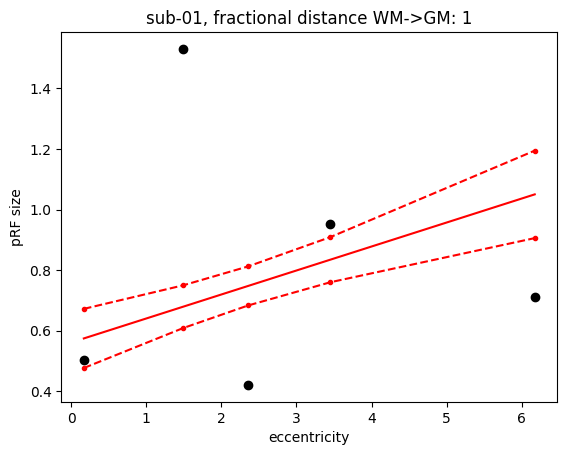

Intercept: 0.5608337366515097
t = 10.77, p = 0.00000
Slope: 0.07927403274056305
t = 4.60, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


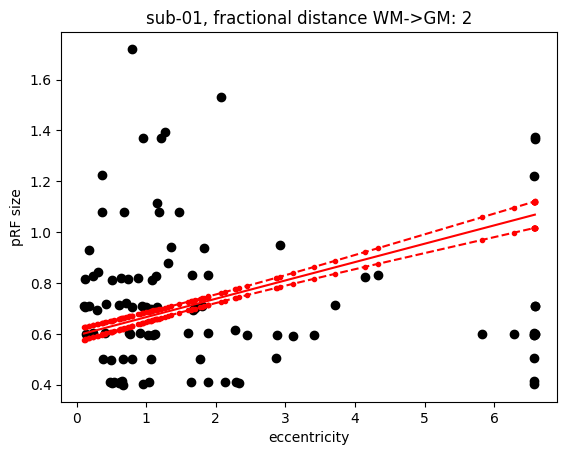

Intercept: 0.5934002126223972
t = 45.23, p = 0.00000
Slope: 0.07218329332294468
t = 13.58, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


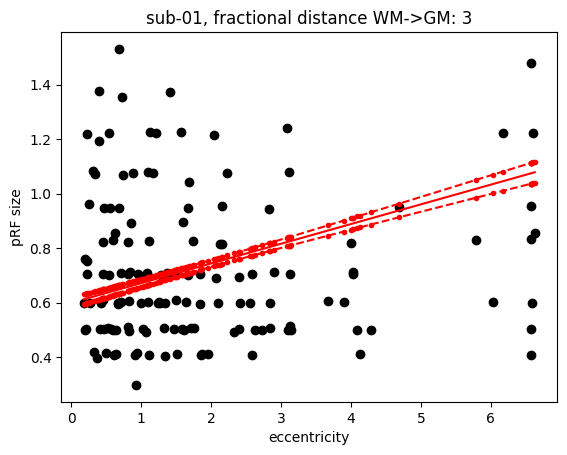

Intercept: 0.5994250584826193
t = 61.58, p = 0.00000
Slope: 0.07224022672159312
t = 18.52, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


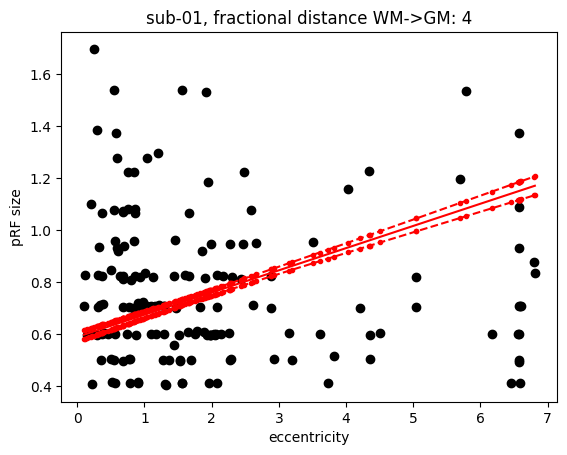

Intercept: 0.5888912273819683
t = 64.97, p = 0.00000
Slope: 0.08533661063005862
t = 23.88, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


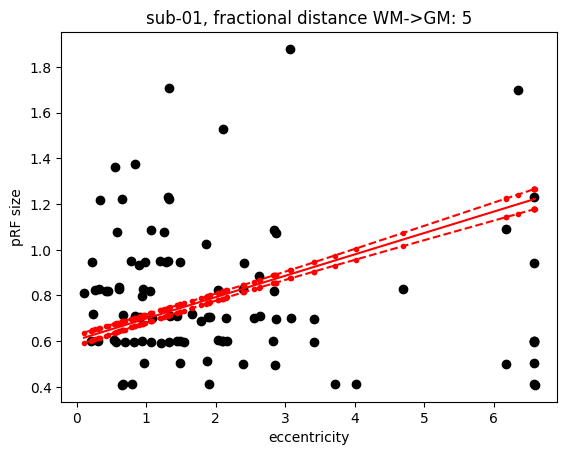

Intercept: 0.6052549288293666
t = 50.90, p = 0.00000
Slope: 0.09360257045522632
t = 20.61, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


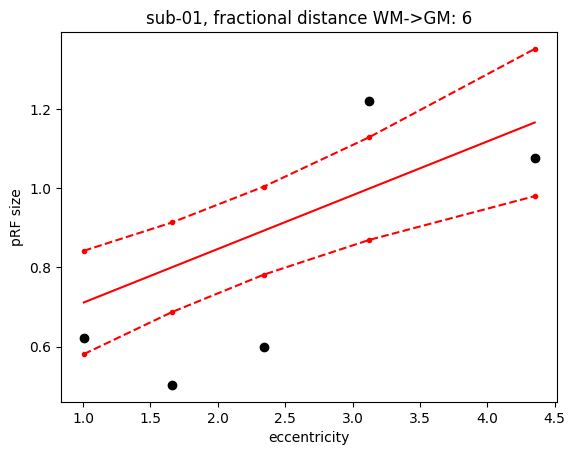

Intercept: 0.5745598034600456
t = 6.42, p = 0.00000
Slope: 0.1358204238342638
t = 4.04, p = 0.00005
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


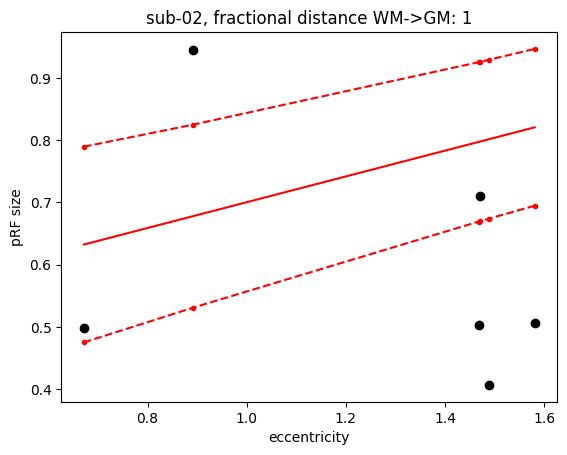

Intercept: 0.49295921196375436
t = 4.96, p = 0.00000
Slope: 0.20735184541673402
t = 5.13, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


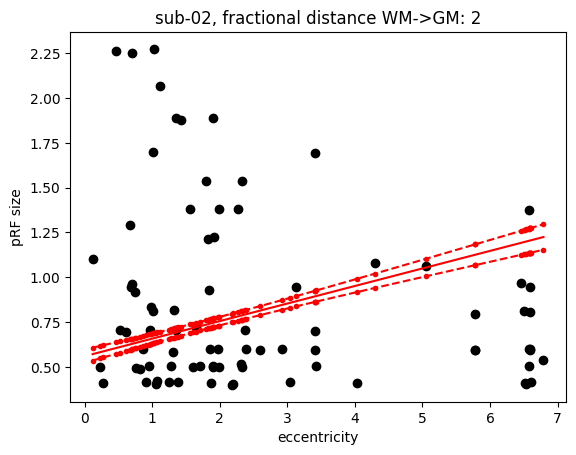

Intercept: 0.5594162111636483
t = 29.63, p = 0.00000
Slope: 0.09792085751943247
t = 13.66, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


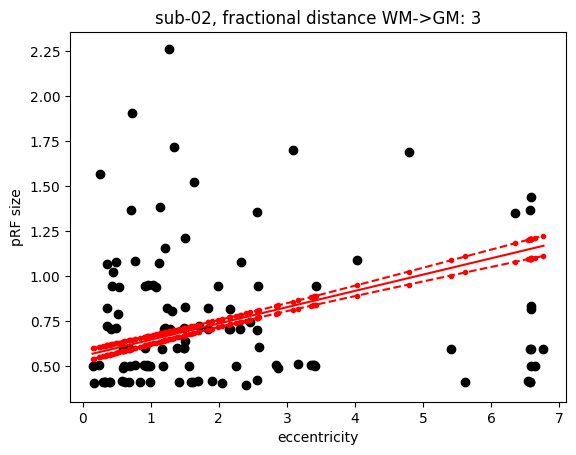

Intercept: 0.5548735830100596
t = 35.05, p = 0.00000
Slope: 0.09062608058624216
t = 15.68, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


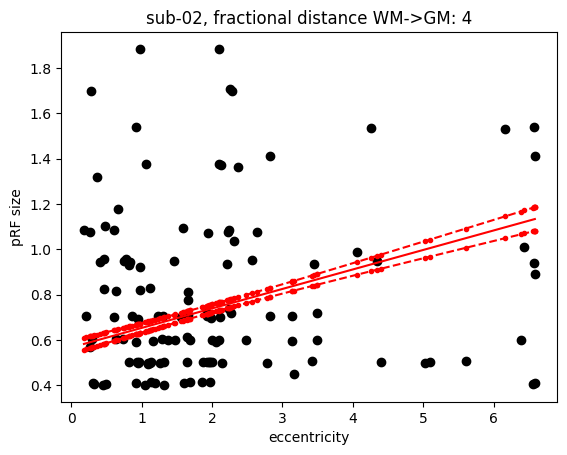

Intercept: 0.566862933189038
t = 39.45, p = 0.00000
Slope: 0.08596018228104992
t = 15.56, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


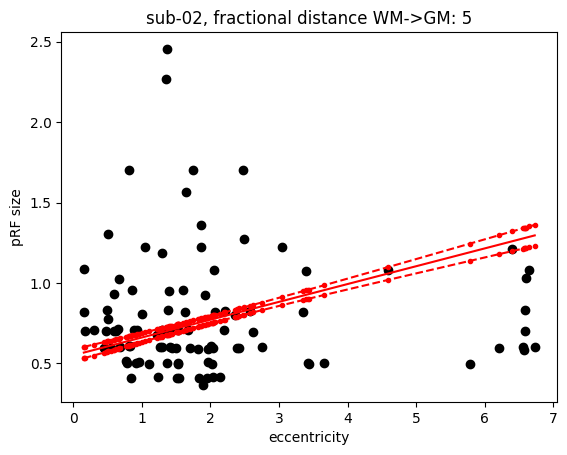

Intercept: 0.5508024649613226
t = 29.19, p = 0.00000
Slope: 0.11072408290143046
t = 16.14, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


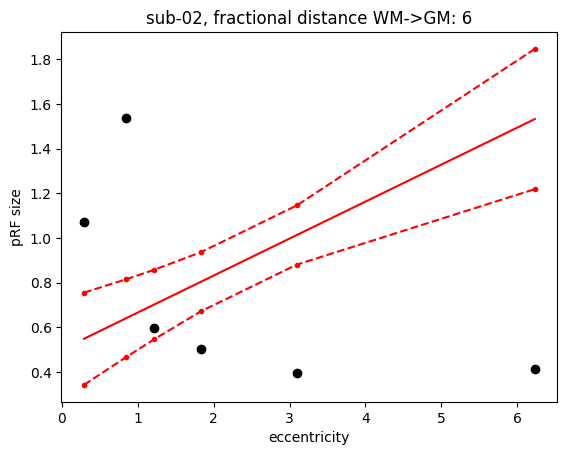

Intercept: 0.5007686508804986
t = 4.37, p = 0.00001
Slope: 0.16547720807426805
t = 4.24, p = 0.00002
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


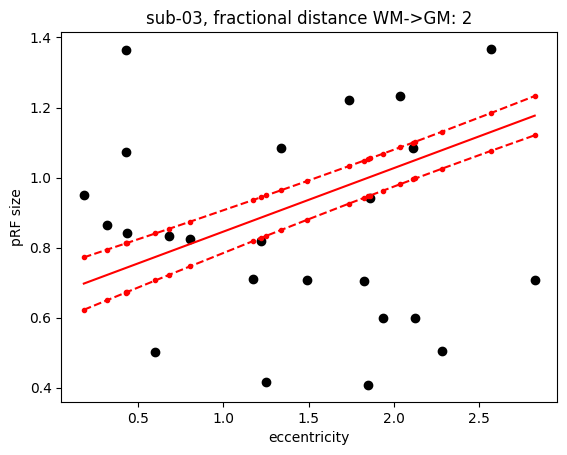

Intercept: 0.6637182037381171
t = 16.56, p = 0.00000
Slope: 0.18166928304015473
t = 12.92, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


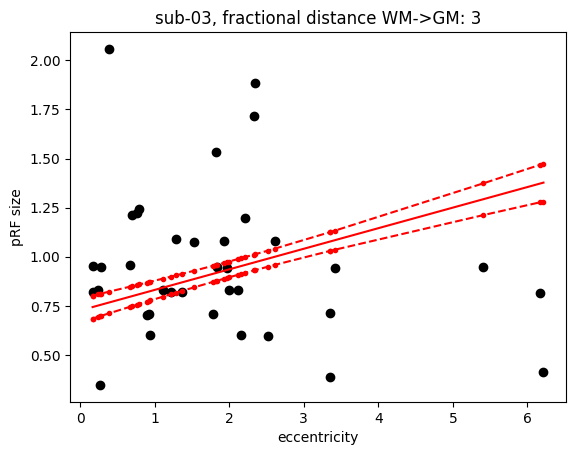

Intercept: 0.7265632488876703
t = 23.27, p = 0.00000
Slope: 0.10473180538257748
t = 9.54, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


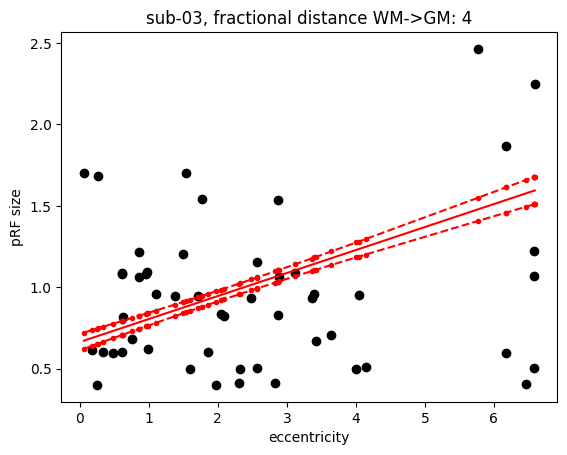

Intercept: 0.6638125653736089
t = 25.69, p = 0.00000
Slope: 0.14114588767518074
t = 15.69, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


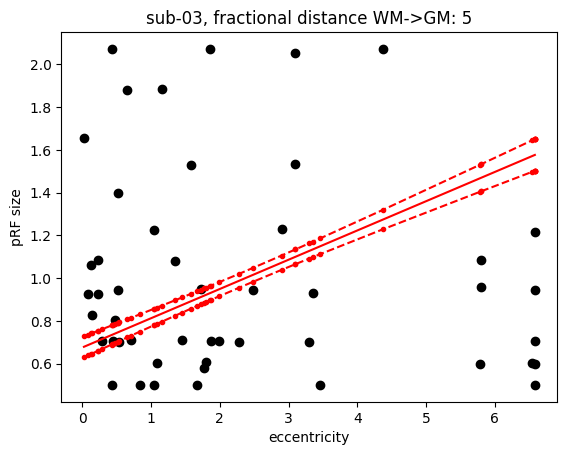

Intercept: 0.6757381321686516
t = 26.78, p = 0.00000
Slope: 0.13688138996743754
t = 16.95, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


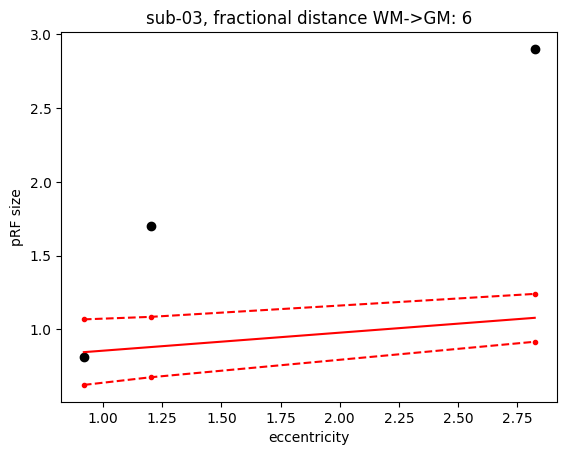

Intercept: 0.732002369940715
t = 4.97, p = 0.00000
Slope: 0.12232320995563863
t = 2.55, p = 0.01065
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


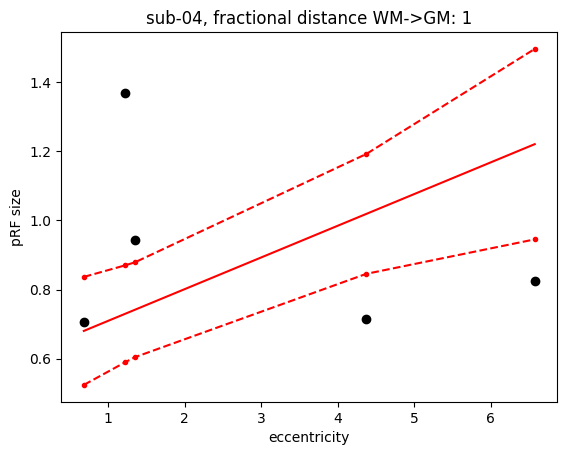

Intercept: 0.6180395706897406
t = 6.66, p = 0.00000
Slope: 0.09164269373394149
t = 3.14, p = 0.00169
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


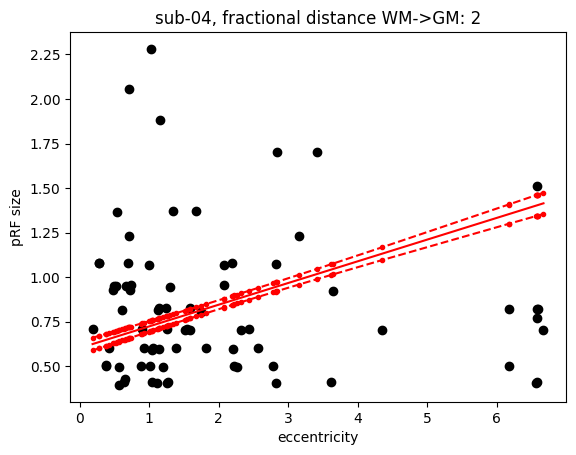

Intercept: 0.6025058938939494
t = 31.67, p = 0.00000
Slope: 0.12169362804718524
t = 19.44, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


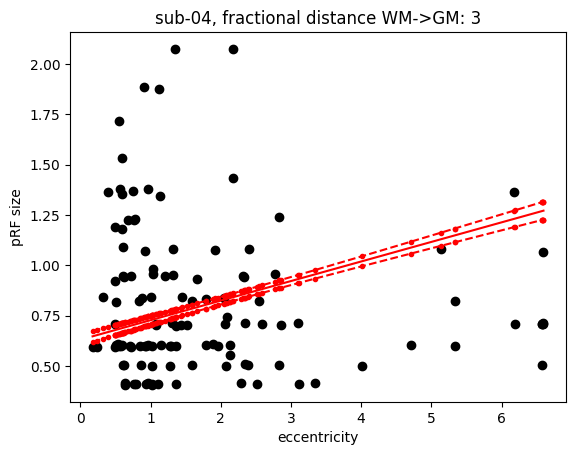

Intercept: 0.6298062133970912
t = 43.25, p = 0.00000
Slope: 0.09720671500368819
t = 20.32, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


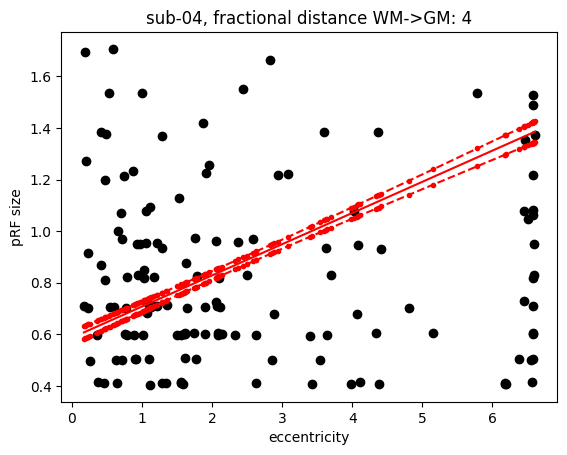

Intercept: 0.5867188846666713
t = 45.09, p = 0.00000
Slope: 0.12085225834016552
t = 27.64, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


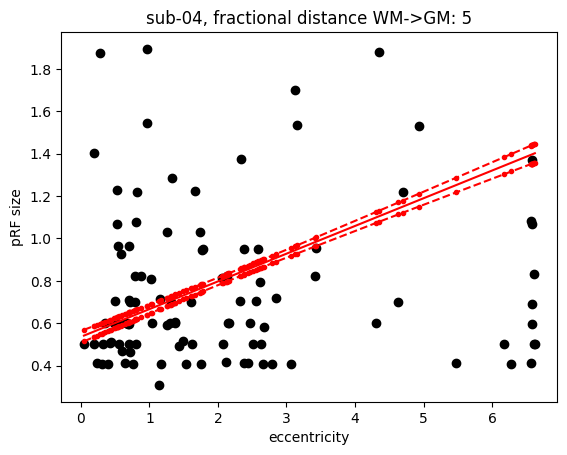

Intercept: 0.5359761972649615
t = 38.24, p = 0.00000
Slope: 0.13079391215444996
t = 27.52, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


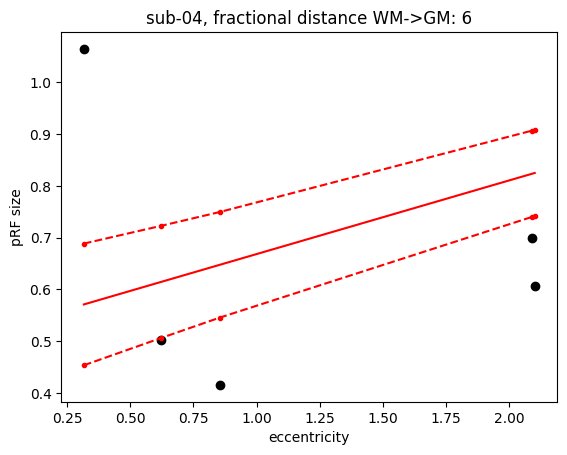

Intercept: 0.5262179276617385
t = 8.08, p = 0.00000
Slope: 0.14212398181412053
t = 6.24, p = 0.00000


In [22]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
#         # bin eccentricity data
#         bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
#         x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 20:
            idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope

    #     # print the quantiles
    #     print("95% quantiles:")
    #     print(quantiles.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

    #     # print the median
    #     print("Median:")
    #     print(median.loc[:, ["mean", "mean_se", "mean_ci_lower", "mean_ci_upper"]])

        # save stats to df
        idx=df_pRFxecc_stats_equivol.loc[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_equivol.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        df_pRFxecc_stats_equivol.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])

        df_pRFxecc_stats_equivol.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol.index[idx])
        
    

In [23]:
df_pRFxecc_stats_equivol.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01    1.0   0.560834  0.079274  t = 10.77, p = 0.00000   
1  sub-01    2.0   0.593400  0.072183  t = 45.23, p = 0.00000   
2  sub-01    3.0   0.599425  0.072240  t = 61.58, p = 0.00000   
3  sub-01    4.0   0.588891  0.085337  t = 64.97, p = 0.00000   
4  sub-01    5.0   0.605255  0.093603  t = 50.90, p = 0.00000   

              slope-stats  pRF@2deg  
0   t = 4.60, p = 0.00000  0.719382  
1  t = 13.58, p = 0.00000  0.737767  
2  t = 18.52, p = 0.00000  0.743906  
3  t = 23.88, p = 0.00000  0.759564  
4  t = 20.61, p = 0.00000  0.792460

#### Plot estimated pRF size at target eccentricity

[ 0.00506796 -0.01222332  0.73246417]
R2 quadratic: 0.9802651046943482
R2 linear: 0.890064125941346
[ 0.02267473 -0.16803924  1.0345378 ]
R2 quadratic: 0.9152123024689723
R2 linear: 0.06710802140368155
[ 0.01640533 -0.13997686  1.23167896]
R2 quadratic: 0.8387057104206664
R2 linear: 0.14121629537005198
[-0.00348348  0.02166785  0.79497722]
R2 quadratic: 0.3469830680722408
R2 linear: 0.07697133946170132


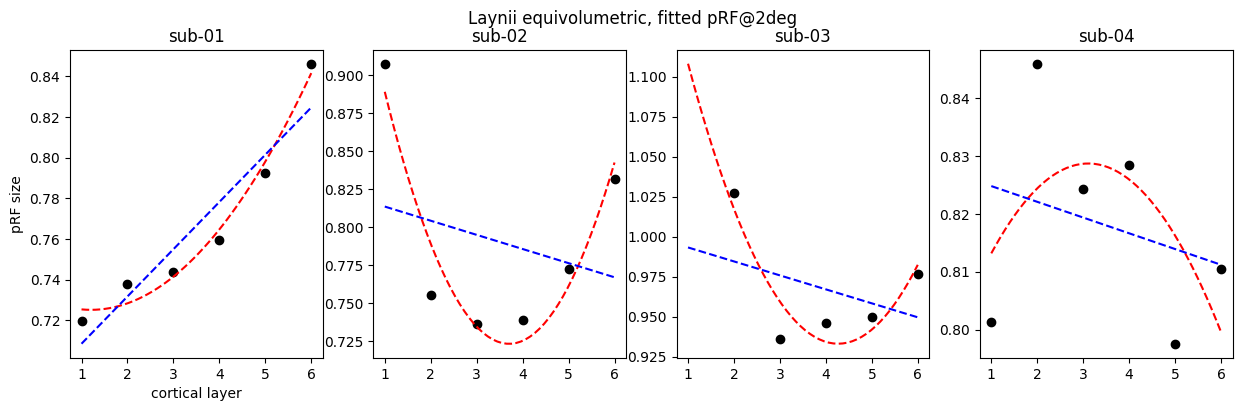

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.0])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.0,5)) 
#     axs[sub_id].set_ylim([0.65, 0.9])
#     axs[sub_id].set_yticks(np.linspace(0.65,0.9,6))  
    
plt.suptitle('Laynii equivolumetric, fitted pRF@2deg')
plt.show()
    
#     df_pRFxecc_stats_equivol.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

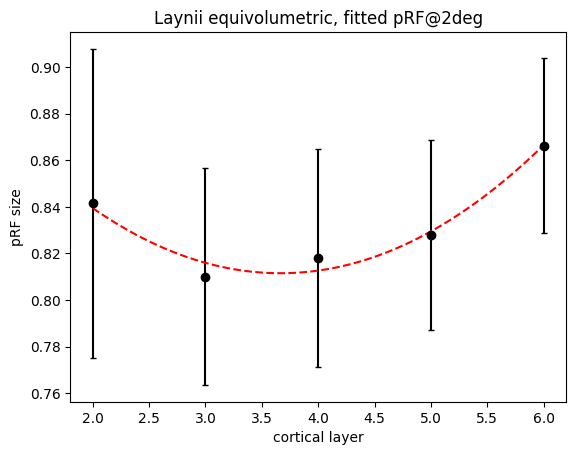

In [25]:
idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol[(df_pRFxecc_stats_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# data for plot
depth_plot    = df_pRFxecc_stats_equivol.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Laynii equivolumetric, fitted pRF@2deg')
plt.show()

## Laynii layers: pRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equidistant layering

#### pRF size at 2deg eccentricity (separately for each cortical layer)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [26]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [27]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [28]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [29]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equidist_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                    (df_equidist_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equidist_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
        
    

In [30]:
df_pRFxecc_stats_equidist_2ecc


sub id  depth  pRF@2deg
0   sub-01    1.0  0.659545
1   sub-01    2.0  0.724164
2   sub-01    3.0  0.742316
3   sub-01    4.0  0.734557
4   sub-01    5.0  0.770134
5   sub-01    6.0  0.825408
6   sub-02    1.0       NaN
7   sub-02    2.0  0.746723
8   sub-02    3.0  0.714752
9   sub-02    4.0  0.700724
10  sub-02    5.0  0.698119
11  sub-02    6.0  0.819884
12  sub-03    1.0       NaN
13  sub-03    2.0  1.115848
14  sub-03    3.0  1.081899
15  sub-03    4.0  1.077545
16  sub-03    5.0  1.080210
17  sub-03    6.0       NaN
18  sub-04    1.0  0.757108
19  sub-04    2.0  0.841692
20  sub-04    3.0  0.878143
21  sub-04    4.0  0.839966
22  sub-04    5.0  0.843880
23  sub-04    6.0  0.899055

#### Plot estimated pRF size at target eccentricity

[4.10171629e-04 2.45421679e-02 6.50568842e-01]
R2 quadratic: 0.8819772611272815
R2 linear: 0.8815562290941458
[ 0.02277817 -0.16925654  1.0030597 ]
R2 quadratic: 0.8700151263945258
R2 linear: 0.1635724344261683
[ 0.00915377 -0.07520328  1.22851106]
R2 quadratic: 0.9739874822304825
R2 linear: 0.6318721417190374
[-0.00494985  0.05402382  0.72929679]
R2 quadratic: 0.6360786475224047
R2 linear: 0.558335746078302


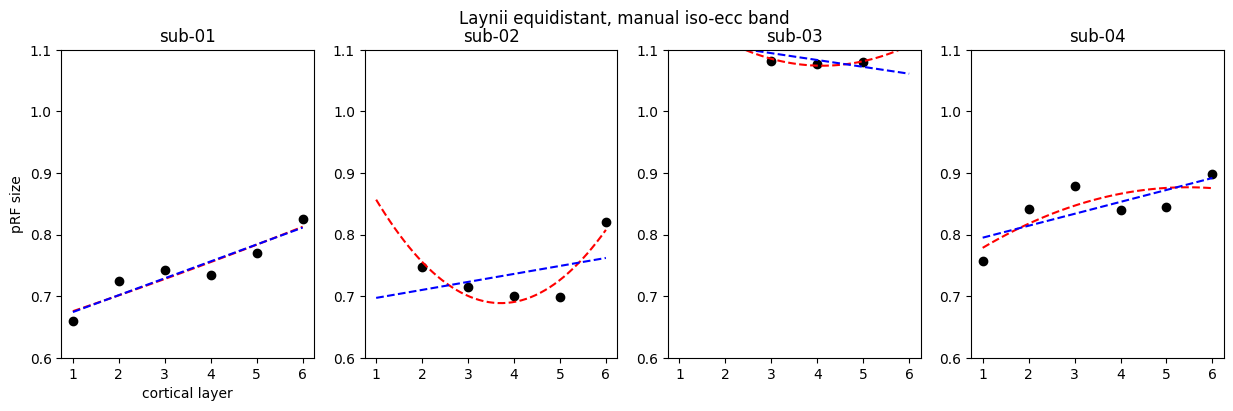

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
    axs[sub_id].set_ylim([0.6, 1.1])
    axs[sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equidist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

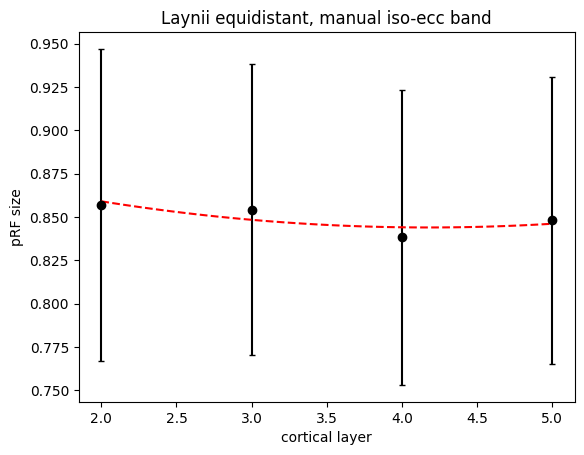

In [32]:
idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equidist_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_equidist_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equidist_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')


plt.title('Laynii equidistant, manual iso-ecc band')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Extract lh and rh sigma and ecc values at chosen rsq threshold

In [33]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Create a dataframe to save intercept and slope stats

In [34]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [35]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        # lh
        idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                          (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                    (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                                 (df_equivol_per_depth_ecc2['roi'] == 'V1') & 
                                    (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                    (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

#         y_sigma = lh_sigma
#         x_ecc = lh_ecc
#         r2 = lh_rsq

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        # bin eccentricity data
        bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        x_ecc=np.digitize(x_ecc,bins=bins)

    #     # random shuffle
    #     shuffle_indices = np.random.permutation(len(y_sigma))
    #     y_sigma = y_sigma[shuffle_indices]
    #     x_ecc = x_ecc[shuffle_indices]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
        
    

In [36]:
df_pRFxecc_stats_equivol_2ecc.head()


sub id  depth  pRF@2deg
0  sub-01    1.0       NaN
1  sub-01    2.0  0.724383
2  sub-01    3.0  0.737668
3  sub-01    4.0  0.739635
4  sub-01    5.0  0.773815

#### Plot estimated pRF size at target eccentricity

[ 0.00522365 -0.02153924  0.74874291]
R2 quadratic: 0.9289160939805614
R2 linear: 0.847026376320933
[ 0.00897542 -0.07006586  0.83499977]
R2 quadratic: 0.998262635411122
R2 linear: 0.6985570544233473
[ 0.02158665 -0.15989828  1.35878518]
R2 quadratic: 0.8985997383488393
R2 linear: 0.15432149095596603
[ 0.00200333 -0.03807541  0.96110346]
R2 quadratic: 0.9757634178212534
R2 linear: 0.9703778602543931


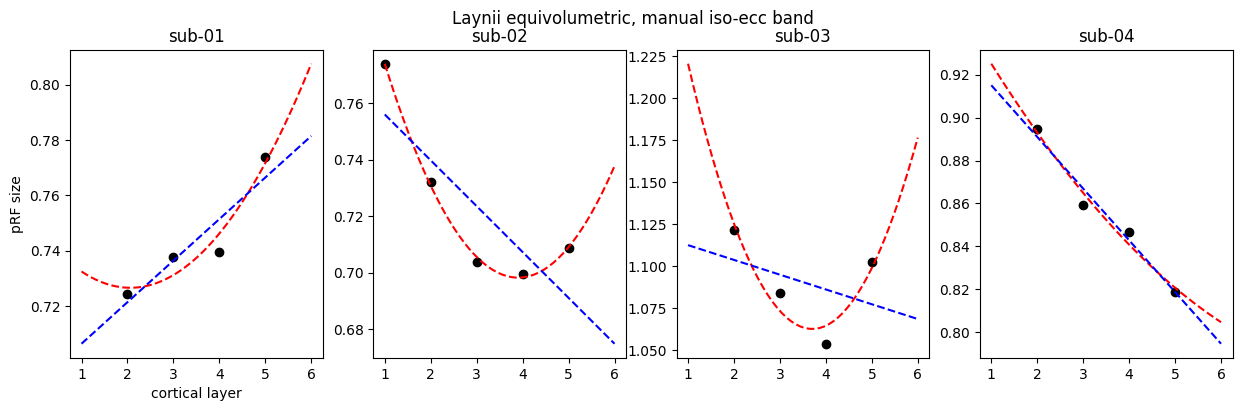

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))


for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(1, n_layers, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.65, 1.15])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6))  
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 
    
plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

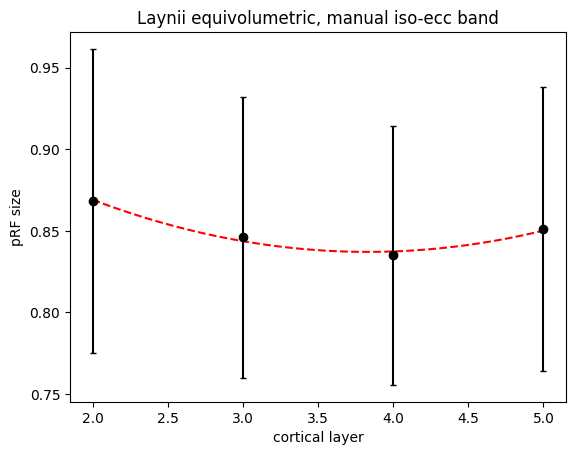

In [38]:
idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_equivol_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)

# ################################################
# # Fit the quadratic equation
# coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

# # Fit the linear equation
# coefs_linear = np.polyfit(depth, pRF_2deg, 1)

# # # Create a polynomial function from the coefficients
# # f_quadratic = np.poly1d(coefs_quadratic)
# # f_linear = np.poly1d(coefs_linear)

# # # calculate the R-squared
# # r_squared = r2_score(pRF_2deg, f_quadratic(depth))
# # print(f"R2 quadratic: {r_squared}")
# # r_squared = r2_score(pRF_2deg, f_linear(depth))
# # print(f"R2 linear: {r_squared}")
# #################################################

# data for plot
depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
#plt.plot(X_plot/n_layers,y_median,'b--')
# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')
plt.title('Laynii equivolumetric, manual iso-ecc band')
plt.show()


## #############################################################

## #############################################################

## Euclidean distances: pRF per cortical layer fitted at target eccentricity

### Equidistant layering

#### pRF size as a function of eccentricity (separately for each cortical layer)
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [39]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Cortical distance bins

In [40]:
cd_bins  = np.linspace(-2.5,2.5,n_layers)
cd_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

Create a dataframe to save intercept and slope stats

In [41]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = cd_bins.tolist()
depths = depth*n_sub

intercept = np.empty((1,len(subs),)).tolist()
intercept = list(itertools.chain(*intercept))

slope = np.empty((1,len(subs),)).tolist()
slope = list(itertools.chain(*slope))

intercept_stats = np.empty((1,len(subs),)).tolist()
intercept_stats = list(itertools.chain(*intercept_stats))

slope_stats = np.empty((1,len(subs),)).tolist()
slope_stats = list(itertools.chain(*slope_stats))

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_cortdist = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'intercept': intercept,
    'slope': slope,
    'intercept-stats' : intercept_stats,
    'slope-stats' : slope_stats,
    'pRF@2deg': pRF_2deg
})

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


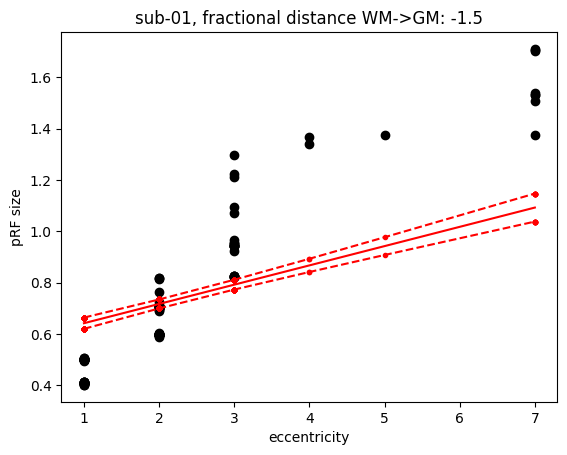

Intercept: 0.5673176871756702
t = 37.21, p = 0.00000
Slope: 0.07500602010854306
t = 13.51, p = 0.00000


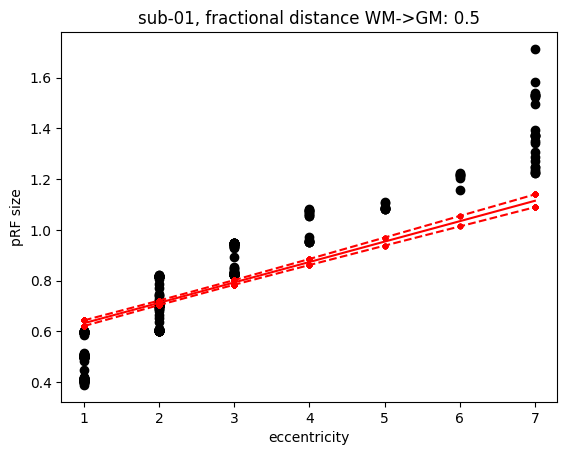

Intercept: 0.5516947198842593
t = 72.33, p = 0.00000
Slope: 0.08042255625761133
t = 30.73, p = 0.00000


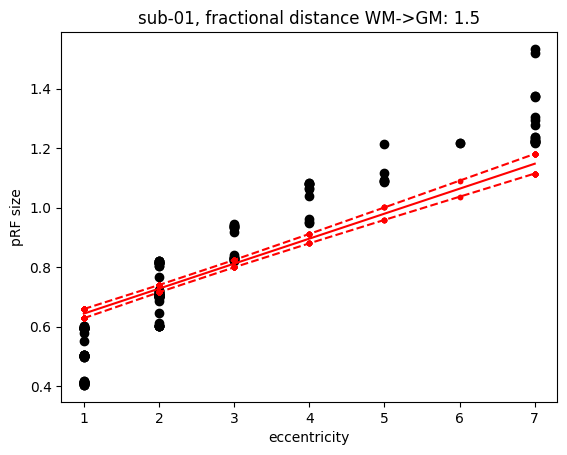

Intercept: 0.5596797374552984
t = 53.76, p = 0.00000
Slope: 0.08400891431824883
t = 24.27, p = 0.00000


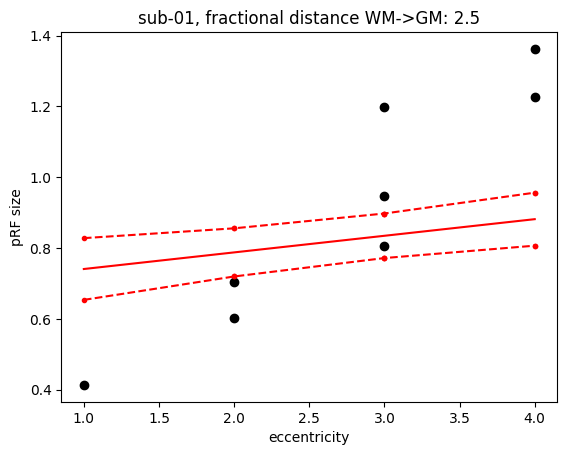

Intercept: 0.6938175954525803
t = 11.97, p = 0.00000
Slope: 0.046943565506708126
t = 2.71, p = 0.00683
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


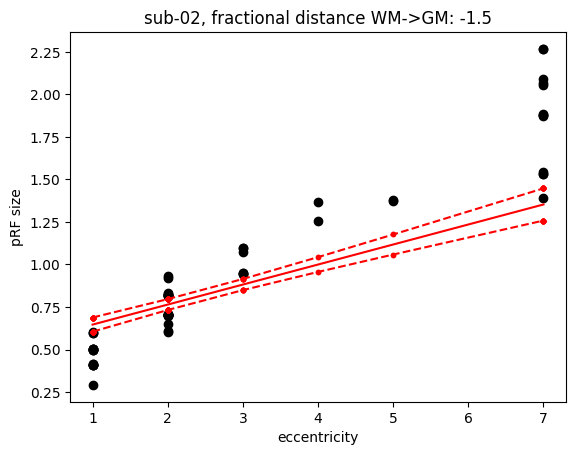

Intercept: 0.5288346919702644
t = 18.26, p = 0.00000
Slope: 0.11771349632343607
t = 11.77, p = 0.00000


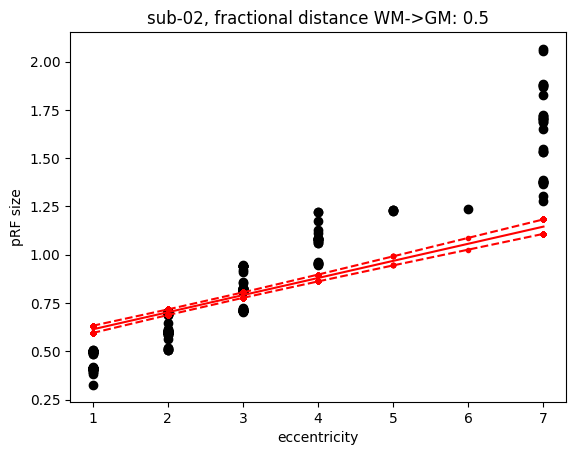

Intercept: 0.5247149569469123
t = 41.73, p = 0.00000
Slope: 0.08867456955123434
t = 22.03, p = 0.00000


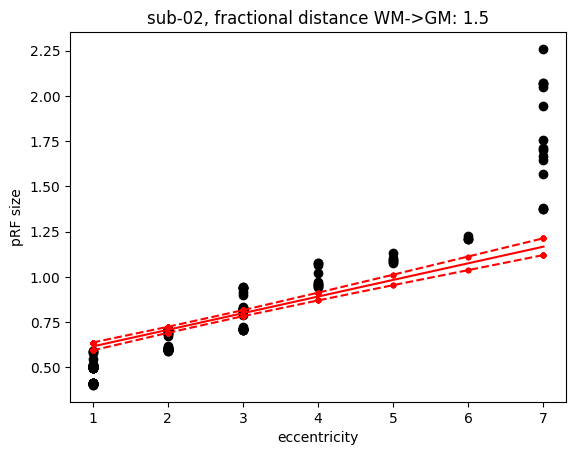

Intercept: 0.5225927445151632
t = 34.99, p = 0.00000
Slope: 0.09202758510662587
t = 18.53, p = 0.00000


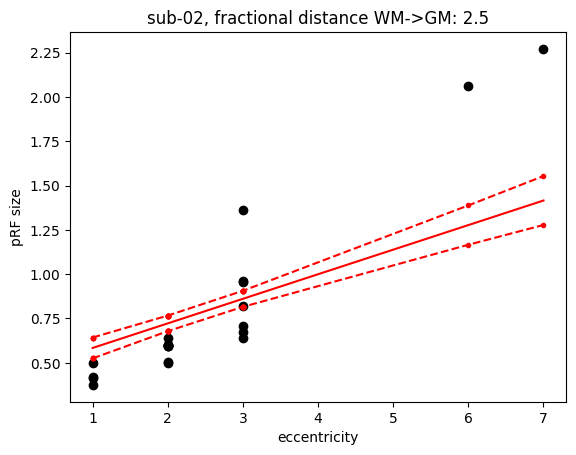

Intercept: 0.44501527981863037
t = 10.70, p = 0.00000
Slope: 0.13862361459220557
t = 9.46, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


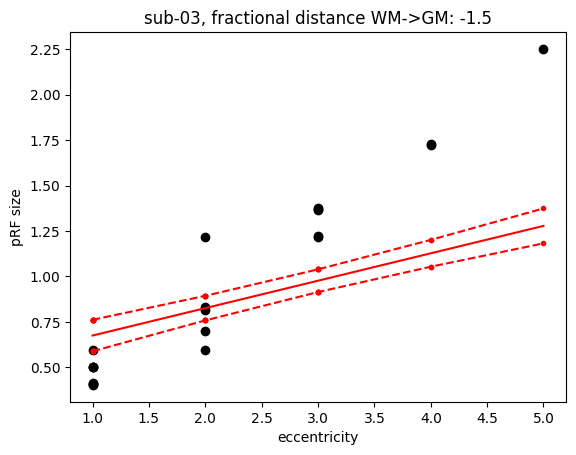

Intercept: 0.5237866599577887
t = 9.14, p = 0.00000
Slope: 0.15082696682896607
t = 8.85, p = 0.00000


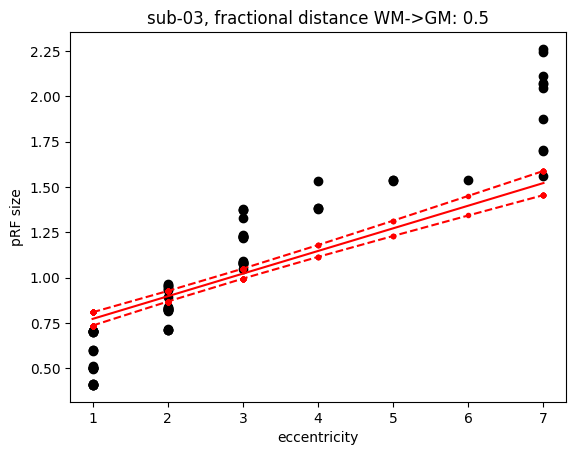

Intercept: 0.646848034266115
t = 26.75, p = 0.00000
Slope: 0.12492246548822969
t = 17.20, p = 0.00000


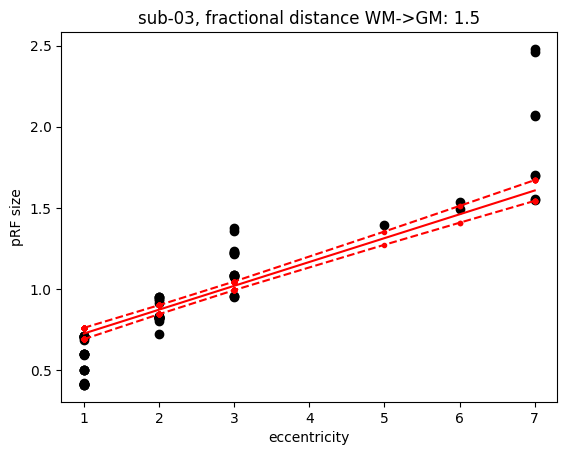

Intercept: 0.5774570288905558
t = 25.14, p = 0.00000
Slope: 0.14705442331079865
t = 21.26, p = 0.00000


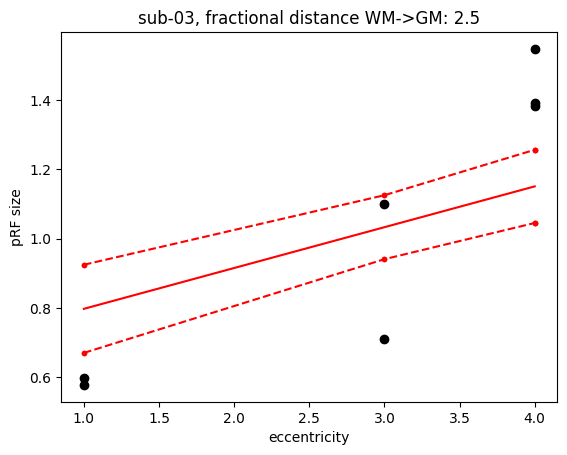

Intercept: 0.6796477463442057
t = 8.19, p = 0.00000
Slope: 0.11769732843024885
t = 4.97, p = 0.00000
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


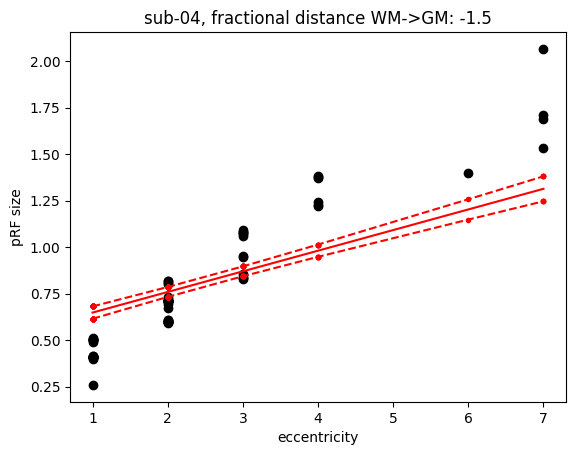

Intercept: 0.5367547999658262
t = 24.39, p = 0.00000
Slope: 0.11091969907594756
t = 15.76, p = 0.00000


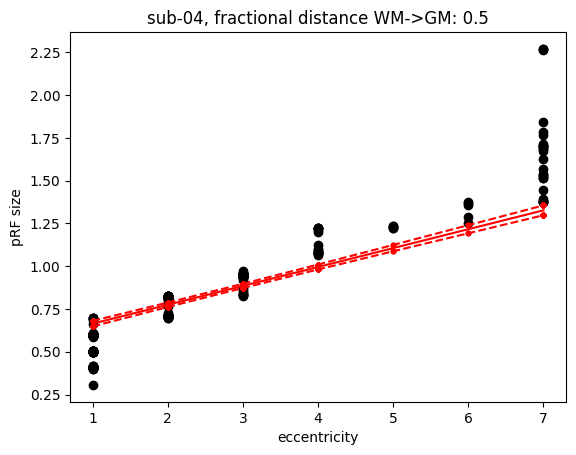

Intercept: 0.553682358109424
t = 52.72, p = 0.00000
Slope: 0.11039249836149548
t = 35.54, p = 0.00000


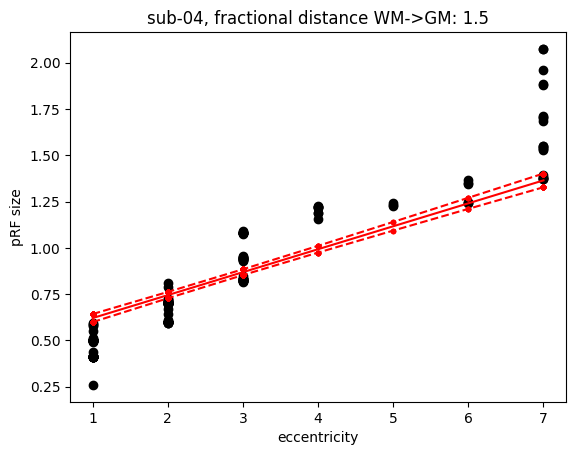

Intercept: 0.49617449190156304
t = 34.74, p = 0.00000
Slope: 0.12402670353888015
t = 29.95, p = 0.00000


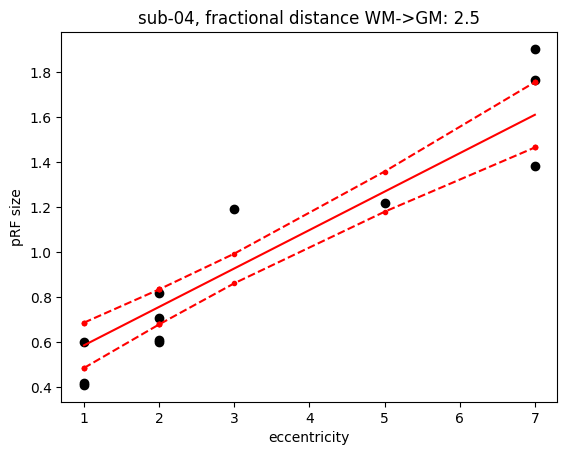

Intercept: 0.41363709413690586
t = 6.29, p = 0.00000
Slope: 0.17095946900407655
t = 9.74, p = 0.00000


In [42]:
for sub_id in range(0,len(subject_list)):
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(subject_list[sub_id])
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    # lh
    idx=df_pRF_per_cortdist.loc[(df_pRF_per_cortdist['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist['roi'] == 'V1') & 
                                (df_pRF_per_cortdist['hem'] == 'lh')].index.tolist()
    lh_sigma = np.stack(df_pRF_per_cortdist.loc[idx, 'pRF size'].to_numpy(), axis=0)
    lh_ecc   = np.stack(df_pRF_per_cortdist.loc[idx, 'ecc'].to_numpy(), axis=0)
    lh_rsq   = np.stack(df_pRF_per_cortdist.loc[idx, 'rsq'].to_numpy(), axis=0)
    lh_cortdist = np.stack(df_pRF_per_cortdist.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # rh
    idx=df_pRF_per_cortdist.loc[(df_pRF_per_cortdist['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist['roi'] == 'V1') & 
                                (df_pRF_per_cortdist['hem'] == 'rh')].index.tolist()
    rh_sigma = np.stack(df_pRF_per_cortdist.loc[idx, 'pRF size'].to_numpy(), axis=0)
    rh_ecc   = np.stack(df_pRF_per_cortdist.loc[idx, 'ecc'].to_numpy(), axis=0)
    rh_rsq   = np.stack(df_pRF_per_cortdist.loc[idx, 'rsq'].to_numpy(), axis=0)
    rh_cortdist = np.stack(df_pRF_per_cortdist.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # concatenate lh&rh
    y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
    x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
    r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
    cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))
    
    # threshold by r2
    y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
    x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
    cortdist    = np.atleast_2d(cortdist[r2>rsq_thresh]).T
    
    # threshold by sigma (only positive)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
    cortdist = np.atleast_2d(cortdist[y_sigma>0]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

    # threshold by sigma (below threshold)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
    cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T

    # also remove outliers
    y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
    y_sigma            = y_sigma[idx_or,:]
    x_ecc              = x_ecc[idx_or,:]
    cortdist           = cortdist[idx_or,:]

    # bin eccentricity data
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    x_ecc=np.digitize(x_ecc,bins=bins)

    # bin cortical distances
    cortdist=np.digitize(cortdist,cd_bins)
    cortdist_=np.zeros(len(cortdist))
    for n in range(0,len(cortdist)):
        cortdist_[n] = cd_bins[(cortdist[n]-1)]
    cortdist=np.expand_dims(cortdist_, axis=1)
    
    # save full array of sigma, ecc
    y_sigma_all=y_sigma
    x_ecc_all=x_ecc
    
    # loop through binned cortical distances
    for depth_idx in depth:
        y_sigma = y_sigma_all[cortdist==depth_idx]
        x_ecc   = x_ecc_all[cortdist==depth_idx]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_cortdist.loc[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_cortdist.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
            continue


        # Split the data into a training set and a test set
        X_train, X_test, y_train, y_test = train_test_split(x_ecc, y_sigma, test_size=0.1)

        # Fit the model to the training set
        X_train = sm.add_constant(X_train)
        #model = sm.OLS(y_train, X_train).fit()
        model = sm.GLM(y_train, X_train, family=sm.families.Gaussian()).fit()

        # Make predictions on the test set
        X_test = sm.add_constant(X_test)
        y_pred = model.predict(X_test)

        # extract the prediction
        pred = model.get_prediction(X_test)

        # extract the intercept and slope
        intercept = model.params[0]
        slope = model.params[1]

        # extract the bootstrapped 95% quantiles and median of the fit
        quantiles = pred.summary_frame(alpha=0.05)
        median = pred.summary_frame(alpha=0.5)

        # plot the model
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_test), 'ko')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(y_pred), 'r-')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_lower'].values), 'r--.')
        plt.plot(np.sort(np.atleast_2d(X_test[:,1])).T, np.sort(quantiles['mean_ci_upper'].values), 'r--.')
        plt.xlabel('eccentricity')
        plt.ylabel('pRF size')
        plt.title(subject_list[sub_id]+", fractional distance WM->GM: "+"{0:.2g}".format(depth_idx))
                  #str(depth_idx/10))
        plt.show()

        # print stats
        print(f"Intercept: {intercept}")
        intercept_txt = "t = "+"{:.2f}".format(model.tvalues[0])+", p = "+"{:.5f}".format(model.pvalues[0])
        print(intercept_txt)

        print(f"Slope: {slope}")
        slope_txt = "t = "+"{:.2f}".format(model.tvalues[1])+", p = "+"{:.5f}".format(model.pvalues[1])
        print(slope_txt)

        # get pRF estimate at 2deg
        pRF_est = intercept + target_ecc*slope


        # save stats to df
        idx=df_pRFxecc_stats_cortdist.loc[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist['depth'] == depth_idx)].index.tolist()
        df_pRFxecc_stats_cortdist.loc[idx, 'intercept-stats'] = pd.Series([intercept_txt]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        df_pRFxecc_stats_cortdist.loc[idx, 'slope-stats'] = pd.Series([slope_txt]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])

        df_pRFxecc_stats_cortdist.loc[idx, 'intercept'] = pd.Series([intercept]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        df_pRFxecc_stats_cortdist.loc[idx, 'slope'] = pd.Series([slope]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])

        df_pRFxecc_stats_cortdist.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_cortdist.index[idx])
        
    

In [43]:
df_pRFxecc_stats_cortdist.head()


sub id  depth  intercept     slope         intercept-stats  \
0  sub-01   -2.5        NaN       NaN                     NaN   
1  sub-01   -1.5   0.567318  0.075006  t = 37.21, p = 0.00000   
2  sub-01   -0.5        NaN       NaN                     NaN   
3  sub-01    0.5   0.551695  0.080423  t = 72.33, p = 0.00000   
4  sub-01    1.5   0.559680  0.084009  t = 53.76, p = 0.00000   

              slope-stats  pRF@2deg  
0                     NaN       NaN  
1  t = 13.51, p = 0.00000  0.717330  
2                     NaN       NaN  
3  t = 30.73, p = 0.00000  0.712540  
4  t = 24.27, p = 0.00000  0.727698

#### Plot estimated pRF size at target eccentricity

[0.01112438 0.00556534 0.70155191]
R2 quadratic: 0.9753083189089277
R2 linear: 0.548009166772894
[ 0.00986458 -0.02001644  0.71169378]
R2 quadratic: 0.9944656524065055
R2 linear: 0.48605071268262934
[-0.00289335  0.02231819  0.86840353]
R2 quadratic: 0.7846534346462339
R2 linear: 0.7613843529178157
[-2.06334589e-03 -5.23966839e-04  7.64278547e-01]
R2 quadratic: 0.21308643876722833
R2 linear: 0.09847726686356029


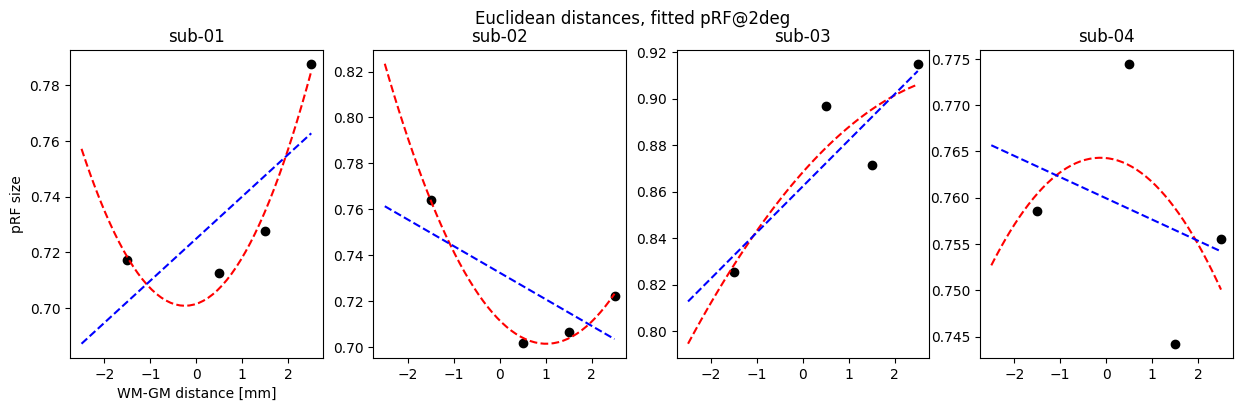

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_cortdist.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_cortdist.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(-2.5, 2.5, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('WM-GM distance [mm]')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.55, 0.95])
#     axs[sub_id].set_yticks(np.linspace(0.55,0.95,5)) 
#     axs[sub_id].set_ylim([0.6, 0.8])
#     axs[sub_id].set_yticks(np.linspace(0.6,0.8,3)) 

plt.suptitle('Euclidean distances, fitted pRF@2deg')
plt.show()
#     axs[sub_id].set_ylim([0.7, 1.1]4
#     axs[sub_id].set_yticks(np.linspace(0.7,1.1,5))    
    
#     df_pRFxecc_stats_cortdist.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

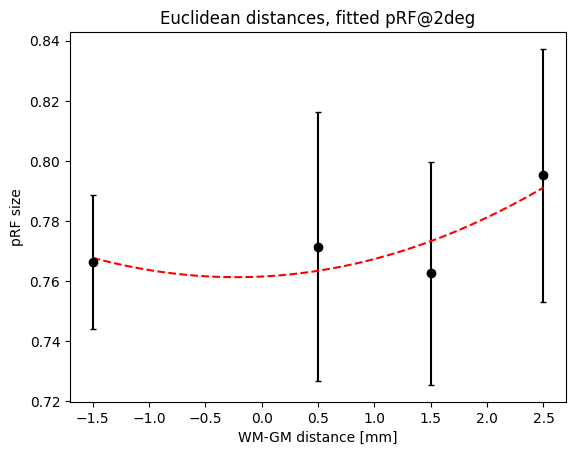

In [45]:
idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_cortdist.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist[(df_pRFxecc_stats_cortdist['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_cortdist['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_cortdist.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_cortdist.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_cortdist.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r--')
# plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('WM-GM distance [mm]')
plt.ylabel('pRF size')


plt.title('Euclidean distances, fitted pRF@2deg')
plt.show()


## Euclidean distances: pRF per cortical layer fitted at manually-defined iso-eccentricity band

#### pRF size at 2deg eccentricity (separately for each cortical depth bin)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [46]:
target_ecc = 2
pRF_thresh = max_ecc_deg

Cortical distance bins

In [47]:
cd_bins  = np.linspace(-2.5,2.5,n_layers)
cd_bins

array([-2.5, -1.5, -0.5,  0.5,  1.5,  2.5])

Create a dataframe to save intercept and slope stats

In [48]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth = cd_bins.tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_cortdist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [49]:
for sub_id in range(0,len(subject_list)):
    # lh
    idx=df_pRF_per_cortdist_ecc2.loc[(df_pRF_per_cortdist_ecc2['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist_ecc2['hem'] == 'lh') & 
                                (df_pRF_per_cortdist_ecc2['roi'] == 'V1')].index.tolist()
    lh_sigma = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
    lh_ecc   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
    lh_rsq   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
    lh_cortdist = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # rh
    idx=df_pRF_per_cortdist_ecc2.loc[(df_pRF_per_cortdist_ecc2['sub id'] == subject_list[sub_id]) & 
                                (df_pRF_per_cortdist_ecc2['hem'] == 'rh') & 
                                (df_pRF_per_cortdist_ecc2['roi'] == 'V1')].index.tolist()
    rh_sigma = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
    rh_ecc   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
    rh_rsq   = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
    rh_cortdist = np.stack(df_pRF_per_cortdist_ecc2.loc[idx, 'cort dist'].to_numpy(), axis=0)

    # concatenate lh&rh
    y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
    x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
    r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
    cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))
    
    # threshold by r2
    y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
    x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
    cortdist    = np.atleast_2d(cortdist[r2>rsq_thresh]).T
    
    # threshold by sigma (only positive)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
    cortdist = np.atleast_2d(cortdist[y_sigma>0]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

    # threshold by sigma (below threshold)
    x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
    cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
    y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T

    # also remove outliers
    y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
    y_sigma            = y_sigma[idx_or,:]
    x_ecc              = x_ecc[idx_or,:]
    cortdist           = cortdist[idx_or,:]

    # bin eccentricity data
    bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    x_ecc=np.digitize(x_ecc,bins=bins)

    # bin cortical distances
    cortdist=np.digitize(cortdist,cd_bins)
    cortdist_=np.zeros(len(cortdist))
    for n in range(0,len(cortdist)):
        cortdist_[n] = cd_bins[(cortdist[n]-1)]
    cortdist=np.expand_dims(cortdist_, axis=1)
    
    # save full array of sigma, ecc
    y_sigma_all=y_sigma
    x_ecc_all=x_ecc
    
    # loop through binned cortical distances
    for depth_idx in depth:
        y_sigma = y_sigma_all[cortdist==depth_idx]
        x_ecc   = x_ecc_all[cortdist==depth_idx]
    
        if len(y_sigma) < 30:
            idx=df_pRFxecc_stats_cortdist_2ecc.loc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist_2ecc['depth'] == depth_idx)].index.tolist()
            df_pRFxecc_stats_cortdist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_cortdist_2ecc.index[idx])
            continue


        # get pRF estimate at 2deg
        pRF_est = np.mean(y_sigma)


        # save stats to df
        idx=df_pRFxecc_stats_cortdist_2ecc.loc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                (df_pRFxecc_stats_cortdist_2ecc['depth'] == depth_idx)].index.tolist()

        df_pRFxecc_stats_cortdist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_cortdist_2ecc.index[idx])
        
    

In [50]:
df_pRFxecc_stats_cortdist_2ecc


sub id  depth  pRF@2deg
0   sub-01   -2.5       NaN
1   sub-01   -1.5  0.740542
2   sub-01   -0.5       NaN
3   sub-01    0.5  0.743006
4   sub-01    1.5  0.743468
5   sub-01    2.5  0.841651
6   sub-02   -2.5       NaN
7   sub-02   -1.5  0.820549
8   sub-02   -0.5       NaN
9   sub-02    0.5  0.726855
10  sub-02    1.5  0.697918
11  sub-02    2.5  0.729583
12  sub-03   -2.5       NaN
13  sub-03   -1.5  0.971377
14  sub-03   -0.5       NaN
15  sub-03    0.5  1.083781
16  sub-03    1.5  1.062798
17  sub-03    2.5  1.125677
18  sub-04   -2.5       NaN
19  sub-04   -1.5  0.852006
20  sub-04   -0.5       NaN
21  sub-04    0.5  0.851193
22  sub-04    1.5  0.831072
23  sub-04    2.5  0.980188

#### Plot estimated pRF size at target eccentricity

[0.01537145 0.00722645 0.71947543]
R2 quadratic: 0.8933337425781203
R2 linear: 0.492040238725882
[ 0.01371164 -0.03778016  0.73435441]
R2 quadratic: 0.9771645196559027
R2 linear: 0.6986004237312586
[-0.00420033  0.0390847   1.04314565]
R2 quadratic: 0.8823817140912102
R2 linear: 0.8649688975027847
[0.02244342 0.00462807 0.81342412]
R2 quadratic: 0.8061282837364184
R2 linear: 0.35502295524450134


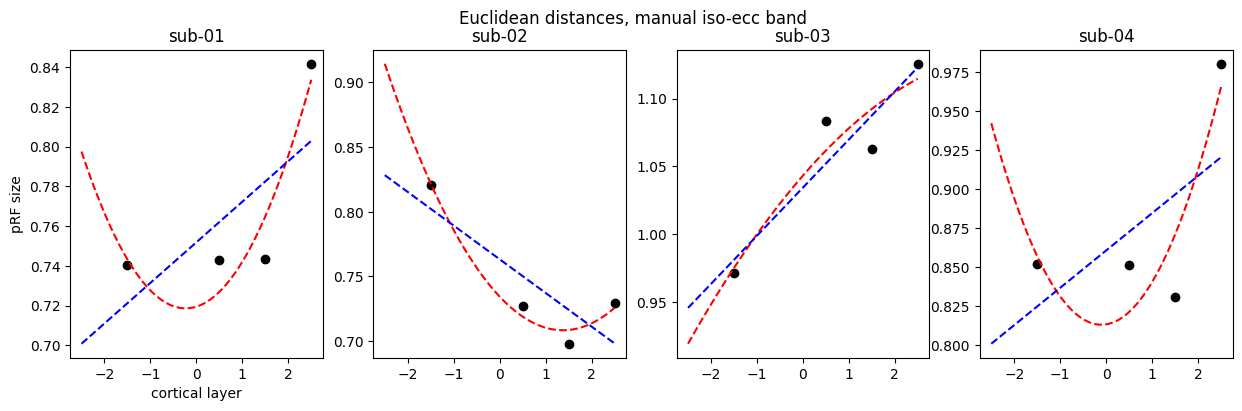

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=len(subject_list), figsize=(15, 4))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id])].index.tolist()
    depth    = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'depth'].values
    pRF_2deg = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'pRF@2deg'].values
    
    # omit nans
    idx = np.isfinite(pRF_2deg)
    pRF_2deg = pRF_2deg[idx]
    depth=depth[idx]
    
    # Fit the quadratic equation
    coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)
    
    # Fit the linear equation
    coefs_linear = np.polyfit(depth, pRF_2deg, 1)

    # Print the coefficients
    print(coefs_quadratic)
    
    # Create a polynomial function from the coefficients
    f_quadratic = np.poly1d(coefs_quadratic)
    f_linear = np.poly1d(coefs_linear)

    # calculate the R-squared
    r_squared = r2_score(pRF_2deg, f_quadratic(depth))
    print(f"R2 quadratic: {r_squared}")
    r_squared = r2_score(pRF_2deg, f_linear(depth))
    print(f"R2 linear: {r_squared}")
    
    # quadratic model fit
    #x = np.linspace(0.2, 0.9, 50)
    x = np.linspace(-2.5, 2.5, 50)
    y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
    y_linear = coefs_linear[0]*x + coefs_linear[1]
    
    # plot the model
    axs[sub_id].plot(depth,pRF_2deg,'ko')
    axs[sub_id].plot(x,y_quadratic,'r--')
    axs[sub_id].plot(x,y_linear,'b--')
    if sub_id == 0:
        axs[sub_id].set_xlabel('cortical layer')
        axs[sub_id].set_ylabel('pRF size')
    axs[sub_id].set_title(subject_list[sub_id])
#     axs[sub_id].set_ylim([0.6, 1.2])
#     axs[sub_id].set_yticks(np.linspace(0.6,1.2,7))   
#     axs[sub_id].set_ylim([0.65, 1.05])
#     axs[sub_id].set_yticks(np.linspace(0.65,1.05,5)) 

plt.suptitle('Euclidean distances, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_cortdist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

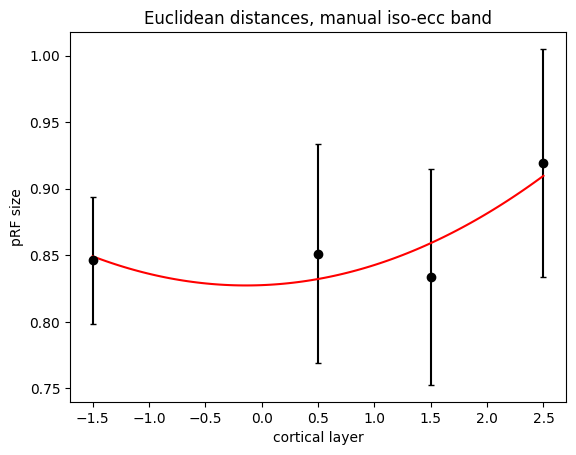

In [52]:
idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[0])].index.tolist()
depth    = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'depth'].values
#depth    = depth[1:]
pRF_2deg = np.empty((len(depth),len(subject_list)))

for sub_id in range(0,len(subject_list)):
    idx      = df_pRFxecc_stats_cortdist_2ecc[(df_pRFxecc_stats_cortdist_2ecc['sub id'] == subject_list[sub_id]) &
                                        (df_pRFxecc_stats_cortdist_2ecc['depth'] >= np.min(depth))].index.tolist()
    pRF_2deg[:,sub_id] = df_pRFxecc_stats_cortdist_2ecc.loc[idx,'pRF@2deg'].values


# omit nans
idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
pRF_2deg = pRF_2deg[idx,:]
depth=depth[idx]
    
# Transform the independent variable into a set of polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(depth.reshape(-1,1))

# Create and fit the model
model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

# Make predictions
X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
X_plot_poly = poly.transform(X_plot)
y_plot = model.predict(X_plot_poly)

y_mean = y_plot.mean(axis=1)
y_median = np.median(y_plot,axis=1)


# data for plot
depth_plot    = df_pRFxecc_stats_cortdist_2ecc.loc[:,'depth'].values
pRF_2deg_plot = df_pRFxecc_stats_cortdist_2ecc.loc[:,'pRF@2deg'].values


# plot
plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), fmt='ko', ecolor='black', capsize=2)
plt.plot(X_plot,y_mean,'r-')
#plt.plot(X_plot/n_layers,y_median,'b--')

# plt.plot(x,y_linear,'b--')
#plt.ylim([0.545,0.60])
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.title('Euclidean distances, manual iso-ecc band')
plt.show()


# ######################################################

# ######################################################

# Pooling data from all participants

Thresholds

In [53]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [54]:
n_layers

6

In [55]:
subs = [['sub-01']*n_layers,['sub-02']*n_layers,['sub-03']*n_layers,['sub-04']*n_layers]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'pRFs': pRF_2deg
})

In [56]:
for depth_idx in depth:
    for sub_id in range(0,len(subject_list)):
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print(subject_list[sub_id])
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        # lh
        idx=df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'lh') & 
                                     (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        lh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        lh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # rh
        idx      = df_equivol_per_depth.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
                                    (df_equivol_per_depth['hem'] == 'rh') & 
                                            (df_equivol_per_depth['roi'] == 'V1') & 
                                    (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
        rh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)
        rh_ecc   = np.stack(df_equivol_per_depth.loc[idx, 'ecc'].to_numpy(), axis=0)
        rh_rsq   = np.stack(df_equivol_per_depth.loc[idx, 'rsq'].to_numpy(), axis=0)

        # concatenate lh&rh
        y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
        x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
        r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

        # threshold by r2
        y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
        x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
        
        # threshold by sigma (only positive)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T
        
        # threshold by sigma (below threshold)
        x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
        y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T
        
        
        # also remove outliers
        y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
        y_sigma            = y_sigma[idx_or,:]
        x_ecc              = x_ecc[idx_or,:]
        
        print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))
        
        
         # save stats to df
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                (df_pRF_filtered_equivol['depth'] == depth_idx)].index.tolist()

        df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])

        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 45
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 55
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 14
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 46
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 961
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%

In [57]:
df_pRF_filtered_equivol.head()

sub id  depth                                               pRFs
0  sub-01    1.0  [[0.7088377653304894], [0.8275785802858038], [...
1  sub-01    2.0  [[0.5028093607754424], [1.365587848190916], [0...
2  sub-01    3.0  [[0.4081223247782812], [0.8171773353547138], [...
3  sub-01    4.0  [[0.40599301206943644], [0.8199405823223472], ...
4  sub-01    5.0  [[0.41236410532122064], [0.6951151121038928], ...

In [58]:
all_sigma_list = []
all_pos_list = []

for depth_idx in depth:
    sigmas_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx)].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
    all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    all_pos_list.append(depth_idx)

In [59]:
pRFsizes = all_sigma_list

Text(0.5, 0, 'Depths (relative index)')

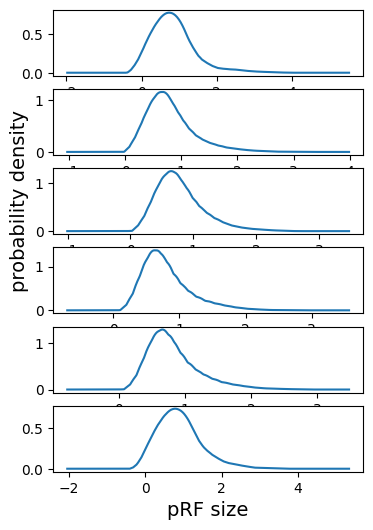

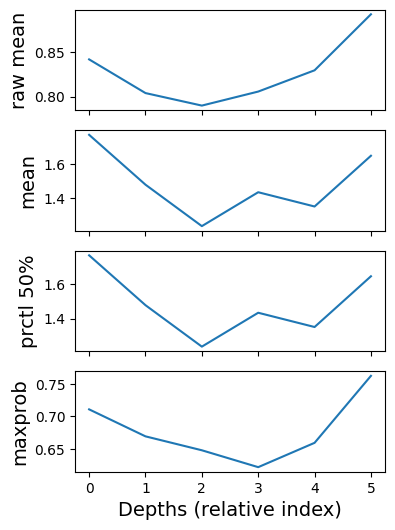

In [60]:
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
ax[2].set_ylabel('probability density', fontsize=14)
ax[len(depth)-1].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

In [61]:
len(all_sigma_list[4])

3469

# ALL ROIS

## Laynii layers: pRF per cortical layer fitted at manually-defined iso-eccentricity band

### Equidistant layering

#### pRF size at 2deg eccentricity (separately for each cortical layer)

##### Extract lh and rh sigma and ecc values at chosen rsq threshold

Thresholds

In [62]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [63]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [64]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equidist_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [65]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equidist_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equidist_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equidist_per_depth_ecc2.loc[(df_equidist_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equidist_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equidist_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equidist_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equidist_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equidist_2ecc.loc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equidist_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equidist_2ecc.index[idx])

    

In [66]:
df_pRFxecc_stats_equidist_2ecc


sub id roi  depth  pRF@2deg
0   sub-01  V1    1.0  0.659545
1   sub-01  V1    2.0  0.724164
2   sub-01  V1    3.0  0.742316
3   sub-01  V1    4.0  0.734557
4   sub-01  V1    5.0  0.770134
..     ...  ..    ...       ...
67  sub-04  V3    2.0  1.037861
68  sub-04  V3    3.0  0.941611
69  sub-04  V3    4.0  0.934164
70  sub-04  V3    5.0  0.965797
71  sub-04  V3    6.0       NaN

[72 rows x 4 columns]

#### Plot estimated pRF size at target eccentricity

[4.10171629e-04 2.45421679e-02 6.50568842e-01]
R2 quadratic: 0.8819772611272815
R2 linear: 0.8815562290941458
[ 0.01013948 -0.07358069  0.9650928 ]
R2 quadratic: 0.9973550831786223
R2 linear: 0.5287474509084578
[ 0.02094094 -0.14399635  1.20519205]
R2 quadratic: 0.2802592214252302
R2 linear: 0.0052593419999420465
[ 0.02277817 -0.16925654  1.0030597 ]
R2 quadratic: 0.8700151263945258
R2 linear: 0.1635724344261683
[-0.00417801 -0.00745169  0.90953804]
R2 quadratic: 0.9511794330791417
R2 linear: 0.9374677325975876
[-0.01185782  0.08854186  0.75733628]
R2 quadratic: 0.27410545190973334
R2 linear: 0.05870914324827925
[ 0.00915377 -0.07520328  1.22851106]
R2 quadratic: 0.9739874822304825
R2 linear: 0.6318721417190374
[-0.0080599   0.04104501  1.17341181]
R2 quadratic: 0.30078550850115593
R2 linear: 0.246572577444522
[ 5.07487353e-04 -4.02432536e-02  1.30125923e+00]
R2 quadratic: 0.24505758747576822
R2 linear: 0.24502008786448037
[-0.00494985  0.05402382  0.72929679]
R2 quadratic: 0.636078647

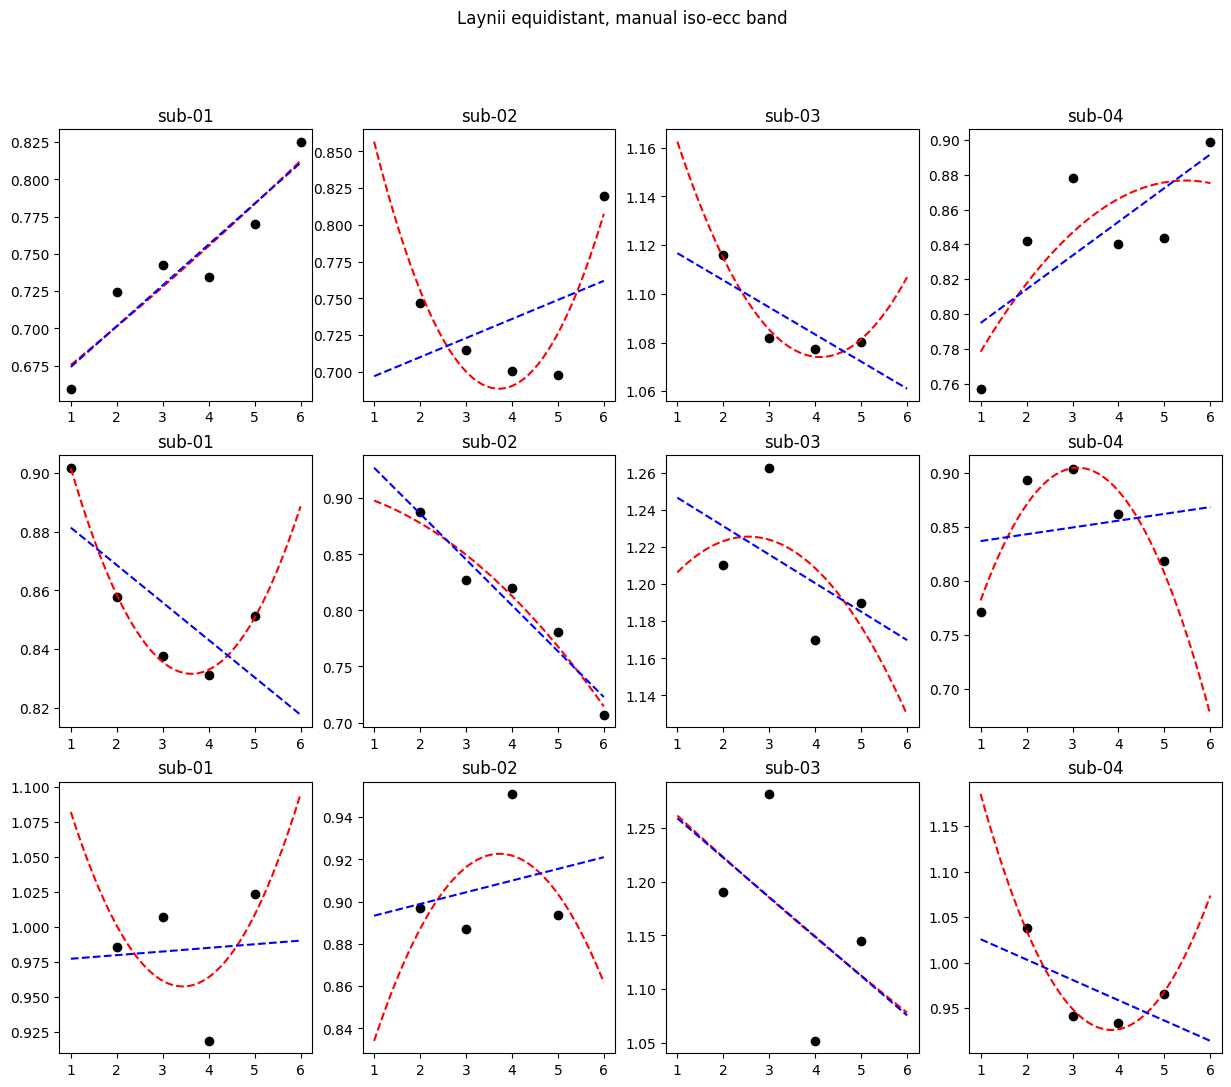

In [67]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
        pRF_2deg = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        # Fit the quadratic equation
        coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

        # Fit the linear equation
        coefs_linear = np.polyfit(depth, pRF_2deg, 1)

        # Print the coefficients
        print(coefs_quadratic)

        # Create a polynomial function from the coefficients
        f_quadratic = np.poly1d(coefs_quadratic)
        f_linear = np.poly1d(coefs_linear)

        # calculate the R-squared
        r_squared = r2_score(pRF_2deg, f_quadratic(depth))
        print(f"R2 quadratic: {r_squared}")
        r_squared = r2_score(pRF_2deg, f_linear(depth))
        print(f"R2 linear: {r_squared}")

        # quadratic model fit
        #x = np.linspace(0.2, 0.9, 50)
        x = np.linspace(1, n_layers, 50)
        y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
        y_linear = coefs_linear[0]*x + coefs_linear[1]

        # plot the model
        axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
        axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
        axs[roi_id,sub_id].plot(x,y_linear,'b--')
        if sub_id == 0 & roi_id == len(roi_list)-1:
            axs[roi_id,sub_id].set_xlabel('cortical layer')
            axs[roi_id,sub_id].set_ylabel('pRF size')
        axs[roi_id,sub_id].set_title(subject_list[sub_id])
    #     axs[sub_id].set_ylim([0.65, 1.15])
    #     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
#         axs[roi_id,sub_id].set_ylim([0.6, 1.1])
#         axs[roi_id,sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equidist_2ecc.loc[(df_equidist_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equidist_per_depth['hem'] == 'lh') & 
#                                 (df_equidist_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equidist_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

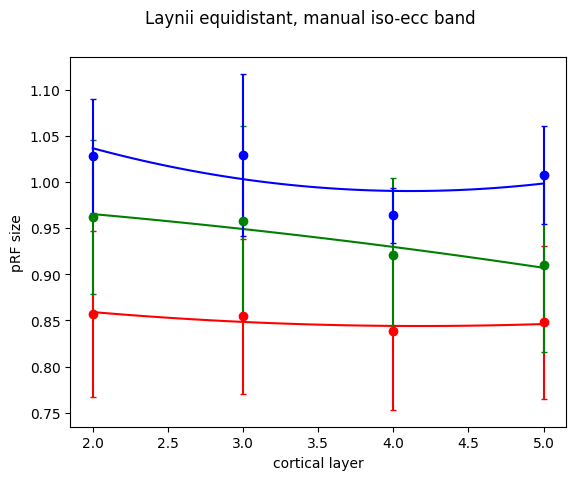

In [68]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equidist_2ecc.loc[idx,'depth'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equidist_2ecc[(df_pRFxecc_stats_equidist_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equidist_2ecc['depth'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equidist_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equidist_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equidist_2ecc.loc[:,'depth'].values
    pRF_2deg_plot = df_pRFxecc_stats_equidist_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        plt.plot(X_plot,y_mean,'b-')
   
plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equidistant, manual iso-ecc band')
plt.show()


### Equivolumetric layering

#### pRF size as a function of eccentricity
Fit a standard GLM to the pRF × eccentricity linear relation

ad Table 1. in "Systematic variation of population receptive field properties across cortical depth in human visual cortex"

Set number of layers, eccentricities, subjects, hemispheres

Thresholds

In [69]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [70]:
np.linspace(1,n_layers,n_layers).tolist()

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

Create a dataframe to save intercept and slope stats

In [71]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))


df_pRFxecc_stats_equivol_2ecc = pd.DataFrame({
    'sub id' : subs,
    'roi' : rois,
    'depth' : depths,
    'pRF@2deg': pRF_2deg
})

In [72]:
for sub_id in range(0,len(subject_list)):
    for depth_idx in depth:
        for roi_id in range(0,len(roi_list)):
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                        (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))

    #         y_sigma = lh_sigma
    #         x_ecc = lh_ecc
    #         r2 = lh_rsq

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]

            # bin eccentricity data
            bins = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            x_ecc=np.digitize(x_ecc,bins=bins)

        #     # random shuffle
        #     shuffle_indices = np.random.permutation(len(y_sigma))
        #     y_sigma = y_sigma[shuffle_indices]
        #     x_ecc = x_ecc[shuffle_indices]

            if len(y_sigma) < 30:
                idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
                df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([np.nan]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])
                continue


            # get pRF estimate at 2deg
            pRF_est = np.mean(y_sigma)
            #pRF_est = np.median(y_sigma)


            # save stats to df
            idx=df_pRFxecc_stats_equivol_2ecc.loc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['depth'] == depth_idx) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()

            df_pRFxecc_stats_equivol_2ecc.loc[idx, 'pRF@2deg'] = pd.Series([pRF_est]*len(idx), index=df_pRFxecc_stats_equivol_2ecc.index[idx])

    

/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:
df_pRFxecc_stats_equivol_2ecc.head()


sub id roi  depth  pRF@2deg
0  sub-01  V1    1.0       NaN
1  sub-01  V1    2.0  0.724383
2  sub-01  V1    3.0  0.737668
3  sub-01  V1    4.0  0.739635
4  sub-01  V1    5.0  0.773815

#### Plot estimated pRF size at target eccentricity

[ 0.00522365 -0.02153924  0.74874291]
R2 quadratic: 0.9289160939805614
R2 linear: 0.847026376320933
[-7.86572437e-04  1.33943714e-03  8.52852433e-01]
R2 quadratic: 0.43063474271847335
R2 linear: 0.4002858424169884
[ 0.01442312 -0.11995279  1.20681642]
R2 quadratic: 0.6354318836551696
R2 linear: 0.43479857137161915
[ 0.00897542 -0.07006586  0.83499977]
R2 quadratic: 0.998262635411122
R2 linear: 0.6985570544233473
[-8.73132433e-04 -2.33770585e-02  9.15386438e-01]
R2 quadratic: 0.8384643284748063
R2 linear: 0.8373729037567281
[-0.01759972  0.12022685  0.72564334]
R2 quadratic: 0.6881612424421982
R2 linear: 0.02367304519661828
[ 0.02158665 -0.15989828  1.35878518]
R2 quadratic: 0.8985997383488393
R2 linear: 0.15432149095596603
[-0.0466002   0.29228269  0.78741771]
R2 quadratic: 0.715417373500146
R2 linear: 0.285022972299816
[-0.02548661  0.13874295  1.03071536]
R2 quadratic: 0.8501410885978083
R2 linear: 0.6390498439355246
[ 0.00200333 -0.03807541  0.96110346]
R2 quadratic: 0.9757634178212

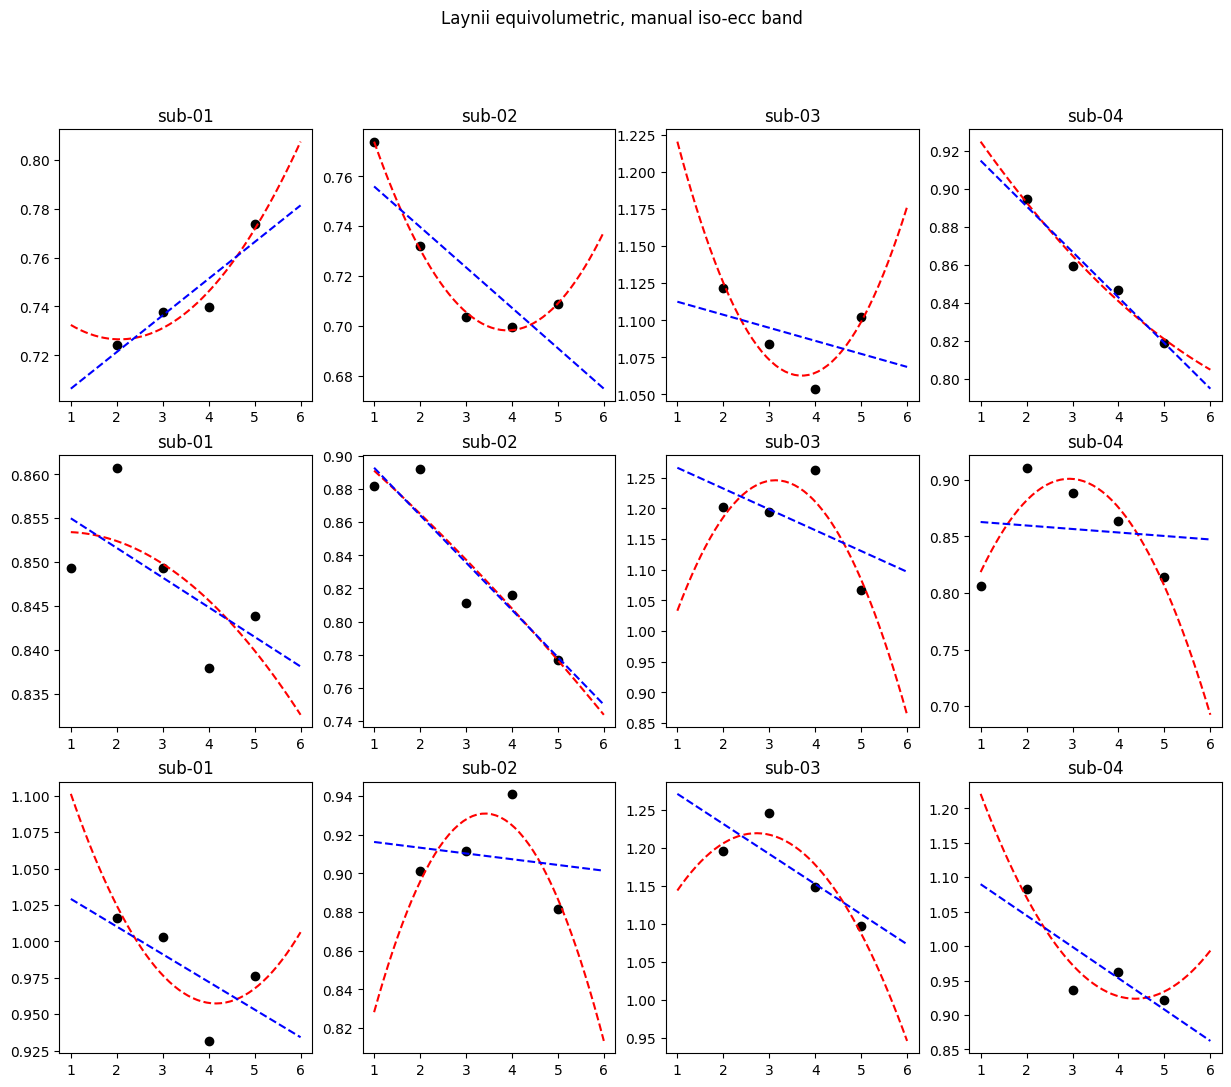

In [74]:
fig, axs = plt.subplots(nrows=len(roi_list), ncols=len(subject_list), figsize=(15, 12))

for sub_id in range(0,len(subject_list)):
    for roi_id in range(0,len(roi_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
        pRF_2deg = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values

        # omit nans
        idx = np.isfinite(pRF_2deg)
        pRF_2deg = pRF_2deg[idx]
        depth=depth[idx]

        # Fit the quadratic equation
        coefs_quadratic = np.polyfit(depth, pRF_2deg, 2)

        # Fit the linear equation
        coefs_linear = np.polyfit(depth, pRF_2deg, 1)

        # Print the coefficients
        print(coefs_quadratic)

        # Create a polynomial function from the coefficients
        f_quadratic = np.poly1d(coefs_quadratic)
        f_linear = np.poly1d(coefs_linear)

        # calculate the R-squared
        r_squared = r2_score(pRF_2deg, f_quadratic(depth))
        print(f"R2 quadratic: {r_squared}")
        r_squared = r2_score(pRF_2deg, f_linear(depth))
        print(f"R2 linear: {r_squared}")

        # quadratic model fit
        #x = np.linspace(0.2, 0.9, 50)
        x = np.linspace(1, n_layers, 50)
        y_quadratic = coefs_quadratic[0]*(x**2) + coefs_quadratic[1]*x+coefs_quadratic[2]
        y_linear = coefs_linear[0]*x + coefs_linear[1]

        # plot the model
        axs[roi_id,sub_id].plot(depth,pRF_2deg,'ko')
        axs[roi_id,sub_id].plot(x,y_quadratic,'r--')
        axs[roi_id,sub_id].plot(x,y_linear,'b--')
        if sub_id == 0 & roi_id == len(roi_list)-1:
            axs[roi_id,sub_id].set_xlabel('cortical layer')
            axs[roi_id,sub_id].set_ylabel('pRF size')
        axs[roi_id,sub_id].set_title(subject_list[sub_id])
    #     axs[sub_id].set_ylim([0.65, 1.15])
    #     axs[sub_id].set_yticks(np.linspace(0.65,1.15,6)) 
#         axs[roi_id,sub_id].set_ylim([0.6, 1.1])
#         axs[roi_id,sub_id].set_yticks(np.linspace(0.6,1.1,6)) 
    

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()
    
#     df_pRFxecc_stats_equivol_2ecc.loc[(df_equivol_per_depth['sub id'] == subject_list[sub_id]) & 
#                                 (df_equivol_per_depth['hem'] == 'lh') & 
#                                 (df_equivol_per_depth['depth'] == depth_idx)].index.tolist()
#     lh_sigma = np.stack(df_equivol_per_depth.loc[idx, 'pRF size'].to_numpy(), axis=0)

##### Group plot

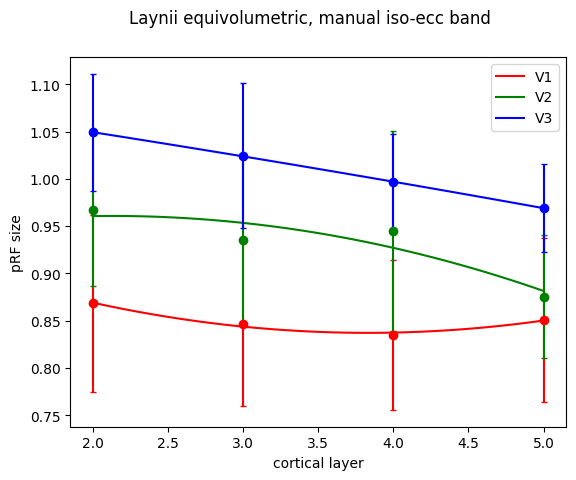

In [75]:
for roi_id in range(0,len(roi_list)):       
    idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[0]) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
    depth    = df_pRFxecc_stats_equivol_2ecc.loc[idx,'depth'].values
    #depth    = depth[1:]
    pRF_2deg = np.empty((len(depth),len(subject_list)))

    for sub_id in range(0,len(subject_list)):
        idx      = df_pRFxecc_stats_equivol_2ecc[(df_pRFxecc_stats_equivol_2ecc['sub id'] == subject_list[sub_id]) &
                                            (df_pRFxecc_stats_equivol_2ecc['depth'] >= np.min(depth)) &
                                    (df_pRFxecc_stats_equivol_2ecc['roi'] == roi_list[roi_id])].index.tolist()
        pRF_2deg[:,sub_id] = df_pRFxecc_stats_equivol_2ecc.loc[idx,'pRF@2deg'].values


    # omit nans
    idx = (np.sum(np.isnan(pRF_2deg),1) == 0)
    pRF_2deg = pRF_2deg[idx,:]
    depth=depth[idx]

    # Transform the independent variable into a set of polynomial features
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(depth.reshape(-1,1))

    # Create and fit the model
    model = MultiOutputRegressor(LinearRegression()).fit(X_poly, pRF_2deg)

    # Make predictions
    X_plot = np.linspace(depth.min(), depth.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)

    y_mean = y_plot.mean(axis=1)
    y_median = np.median(y_plot,axis=1)


    # data for plot
    depth_plot    = df_pRFxecc_stats_equivol_2ecc.loc[:,'depth'].values
    pRF_2deg_plot = df_pRFxecc_stats_equivol_2ecc.loc[:,'pRF@2deg'].values


    # plot
    if roi_id == 0:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='ro')
        line1=plt.plot(X_plot,y_mean,'r-')
    elif roi_id == 1:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='go')
        line2=plt.plot(X_plot,y_mean,'g-')
    elif roi_id == 2:
        plt.errorbar(depth, pRF_2deg.mean(axis=1), yerr=stats.sem(pRF_2deg,axis=1), capsize=2, fmt='bo')
        line3=plt.plot(X_plot,y_mean,'b-')
        
   
plt.legend(['V1', 'V2', 'V3'])

plt.xlabel('cortical layer')
plt.ylabel('pRF size')

plt.suptitle('Laynii equivolumetric, manual iso-ecc band')
plt.show()


# Pooling and max prob of fitted distribution

Set number of layers, eccentricities, subjects, hemispheres

Thresholds

In [76]:
target_ecc = 2
pRF_thresh = max_ecc_deg

In [77]:
subs = [['sub-01']*n_layers*n_rois,['sub-02']*n_layers*n_rois,['sub-03']*n_layers*n_rois,['sub-04']*n_layers*n_rois]
subs = list(itertools.chain(*subs))

depth  = np.linspace(1,n_layers,n_layers).tolist()
depths = depth*n_sub*n_rois

rois = [['V1']*n_layers,['V2']*n_layers,['V3']*n_layers]
rois = list(itertools.chain(*rois))*n_sub

pRF_2deg = np.empty((1,len(subs),)).tolist()
pRF_2deg = list(itertools.chain(*pRF_2deg))

cortdist = np.empty((1,len(subs),)).tolist()
cortdist = list(itertools.chain(*cortdist))


df_pRF_filtered_equivol = pd.DataFrame({
    'sub id' : subs,
    'depth' : depths,
    'roi' : rois,
    'pRFs': pRF_2deg,
    'cortdist': cortdist
})

In [78]:
for roi_id in range(0,len(roi_list)):  
    for depth_idx in depth:
        for sub_id in range(0,len(subject_list)):
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            print(subject_list[sub_id])
            print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
            # lh
            idx=df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'lh') & 
                                         (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            lh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            lh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            lh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
            lh_cortdist = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'cortdist'].to_numpy(), axis=0)

            # rh
            idx      = df_equivol_per_depth_ecc2.loc[(df_equivol_per_depth_ecc2['sub id'] == subject_list[sub_id]) & 
                                        (df_equivol_per_depth_ecc2['hem'] == 'rh') & 
                                                (df_equivol_per_depth_ecc2['roi'] == roi_list[roi_id]) & 
                                        (df_equivol_per_depth_ecc2['depth'] == depth_idx)].index.tolist()
            rh_sigma = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'pRF size'].to_numpy(), axis=0)
            rh_ecc   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'ecc'].to_numpy(), axis=0)
            rh_rsq   = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'rsq'].to_numpy(), axis=0)
            rh_cortdist = np.stack(df_equivol_per_depth_ecc2.loc[idx, 'cortdist'].to_numpy(), axis=0)

            # concatenate lh&rh
            y_sigma  = np.concatenate((lh_sigma.T,rh_sigma.T))
            x_ecc    = np.concatenate((lh_ecc.T,rh_ecc.T))
            r2       = np.concatenate((lh_rsq.T,rh_rsq.T))
            cortdist = np.concatenate((lh_cortdist.T,rh_cortdist.T))

            # threshold by r2
            y_sigma  = np.atleast_2d(y_sigma[r2>rsq_thresh]).T
            x_ecc    = np.atleast_2d(x_ecc[r2>rsq_thresh]).T
            cortdist = np.atleast_2d(cortdist[r2>rsq_thresh]).T

            # threshold by sigma (only positive)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma>0]).T
            cortdist    = np.atleast_2d(cortdist[y_sigma>0]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma>0]).T

            # threshold by sigma (below threshold)
            x_ecc    = np.atleast_2d(x_ecc[y_sigma<pRF_thresh]).T
            cortdist = np.atleast_2d(cortdist[y_sigma<pRF_thresh]).T
            y_sigma  = np.atleast_2d(y_sigma[y_sigma<pRF_thresh]).T


            # also remove outliers
            y_sigma_or, idx_or = reject_outliers(np.squeeze(y_sigma))
            y_sigma            = y_sigma[idx_or,:]
            x_ecc              = x_ecc[idx_or,:]
            cortdist           = cortdist[idx_or,:]

            print('Nr voxels at layer '+str(depth_idx)+': '+str(len(y_sigma)))


             # save stats to df
            idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                    (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                    (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()

            df_pRF_filtered_equivol.loc[idx, 'pRFs'] = pd.Series([y_sigma], index=df_pRF_filtered_equivol.index[idx])
            df_pRF_filtered_equivol.loc[idx, 'cortdist'] = pd.Series([cortdist], index=df_pRF_filtered_equivol.index[idx])
        

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 19
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 32
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 1.0: 27
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-01
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 2.0: 459
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-02
%%%%%%%%%%%%%%%%%%%%

Nr voxels at layer 6.0: 6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-03
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
sub-04
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Nr voxels at layer 6.0: 2


/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [79]:
df_pRF_filtered_equivol.head()

sub id  depth roi                                               pRFs  \
0  sub-01    1.0  V1  [[0.4076564364069129], [0.4053797337429109], [...   
1  sub-01    2.0  V1  [[0.5028093607754424], [1.365587848190916], [0...   
2  sub-01    3.0  V1  [[0.4081223247782812], [0.8171773353547138], [...   
3  sub-01    4.0  V1  [[0.8199405823223472], [0.7084127107869987], [...   
4  sub-01    5.0  V1  [[0.41236410532122064], [0.6951151121038928], ...   

                                            cortdist  
0  [[0.8], [0.8], [0.8], [0.8], [0.8], [0.8], [0....  
1  [[1.1313708498984762], [0.8], [0.8], [0.8], [0...  
2  [[1.6], [1.6], [1.3856406460551018], [1.6], [1...  
3  [[1.6], [1.3856406460551018], [1.7888543819998...  
4  [[2.4000000000000004], [2.4000000000000004], [...

In [80]:
V1_all_sigma_list = []
V1_all_pos_list = []
V1_cortdist_list = []
roi_id = 0

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V1_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V1_all_pos_list.append(depth_idx)
    V1_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))
    
    
V2_all_sigma_list = []
V2_all_pos_list = []
V2_cortdist_list = []
roi_id = 1

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V2_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V2_all_pos_list.append(depth_idx)
    V2_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))

V3_all_sigma_list = []
V3_all_pos_list = []
V3_cortdist_list = []
roi_id = 2

for depth_idx in depth:
    sigmas_thisdepth = []
    cortdist_thisdepth = []
    for sub_id in range(0,len(subject_list)):
        idx=df_pRF_filtered_equivol.loc[(df_pRF_filtered_equivol['sub id'] == subject_list[sub_id]) &
                                        (df_pRF_filtered_equivol['depth'] == depth_idx) &
                                        (df_pRF_filtered_equivol['roi'] == roi_list[roi_id])].index.tolist()
        sigmas_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'pRFs'].values[0])
        cortdist_thisdepth.append(df_pRF_filtered_equivol.loc[idx, 'cortdist'].values[0])
    V3_all_sigma_list.append(np.array(flatten(sigmas_thisdepth)))
    V3_all_pos_list.append(depth_idx)
    V3_cortdist_list.append(np.array(flatten(cortdist_thisdepth)))

In [81]:
np.save('V1_all_sigma_list_'+prf_model,V1_all_sigma_list)
np.save('V2_all_sigma_list_'+prf_model,V2_all_sigma_list)
np.save('V3_all_sigma_list_'+prf_model,V3_all_sigma_list)

np.save('V1_cortdist_list_'+prf_model,V1_cortdist_list)
np.save('V2_cortdist_list_'+prf_model,V2_cortdist_list)
np.save('V3_cortdist_list_'+prf_model,V3_cortdist_list)

/home/mayajas/.conda/envs/py38prf/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [82]:
# np.histogram(V3_cortdist_list[1])

## Bootstrapping

In [83]:
# non-parametric fit parameters
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

# Set the number of bootstrap samples, depths
n_boot = 1000
n_depth = len(depth)


In [84]:
try:
    V1_maxprobs=np.load('V1_maxprobs_'+prf_model+'.npy')
    V2_maxprobs=np.load('V2_maxprobs_'+prf_model+'.npy')
    V3_maxprobs=np.load('V3_maxprobs_'+prf_model+'.npy')
except:
    
    # Create an array to store the maximum probability values
    V1_maxprobs = np.zeros([n_depth,n_boot])
    V2_maxprobs = np.zeros([n_depth,n_boot])
    V3_maxprobs = np.zeros([n_depth,n_boot])


    # Generate bootstrap samples and calculate the maximum probability value for each sample
    # V1
    pRFsizes = V1_all_sigma_list
    print('V1 bootstrapping')
    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V1_maxprobs[n,i] = s[idx]

    # V2
    pRFsizes = V2_all_sigma_list
    print('V2 bootstrapping')

    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V2_maxprobs[n,i] = s[idx]

    # V3
    pRFsizes = V3_all_sigma_list
    print('V3 bootstrapping')

    for n in range(0,len(depth)):
            data = np.squeeze(pRFsizes[n])
            print('depth '+str(n))
            for i in range(n_boot):
                sample = np.random.choice(data, size=len(data), replace=True)

                dens = sm.nonparametric.KDEUnivariate(sample)
                dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj)

                s = dens.support
                idx = np.argmax(dens.density)
                V3_maxprobs[n,i] = s[idx]

    np.save('V1_maxprobs_'+prf_model,V1_maxprobs)
    np.save('V2_maxprobs_'+prf_model,V2_maxprobs)
    np.save('V3_maxprobs_'+prf_model,V3_maxprobs)

## V1

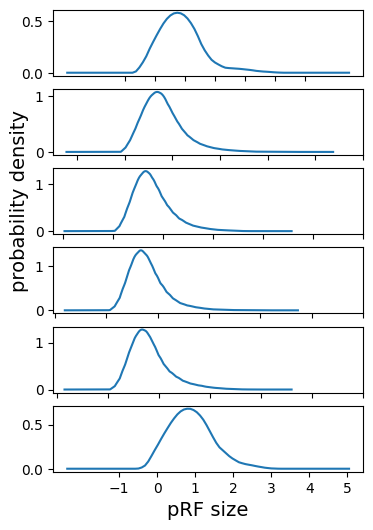

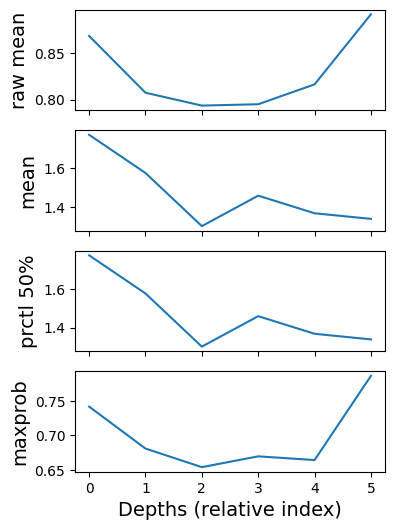

In [85]:
pRFsizes = V1_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V1_CI_lower = np.zeros([n_depth,])
V1_CI_upper = np.zeros([n_depth,])
V1_SE = np.zeros([n_depth,])
V1_SD = np.zeros([n_depth,])
V1_HDI = np.zeros([n_depth,2])


fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V1_HDI[n,:] = [x[idx1], x[idx2]]

    # get bootstrapped CI's
    V1_CI_lower[n] = np.percentile(V1_maxprobs[n,:], 2.5)
    V1_CI_upper[n] = np.percentile(V1_maxprobs[n,:], 97.5)
    
    V1_SE[n] = np.std(V1_maxprobs[n,:], ddof=1) / np.sqrt(n_boot)
    V1_SD[n] = np.std(V1_maxprobs[n,:], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V1_sigmas=sigmas

## V2

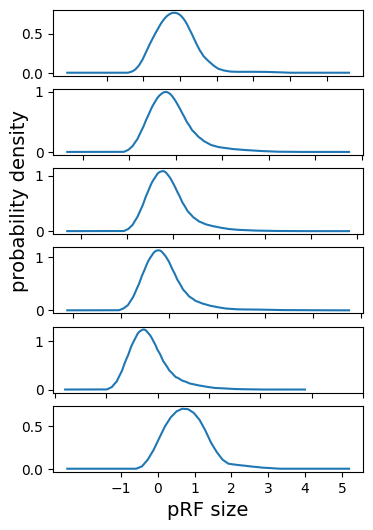

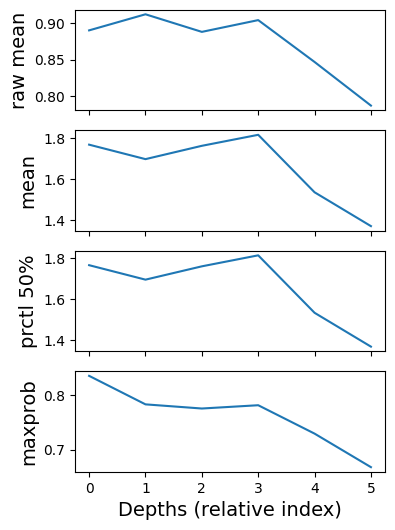

In [86]:
pRFsizes = V2_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V2_CI_lower = np.zeros([n_depth,])
V2_CI_upper = np.zeros([n_depth,])
V2_SE = np.zeros([n_depth,])
V2_SD = np.zeros([n_depth,])
V2_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V2_HDI[n,:] = [x[idx1], x[idx2]]
    
    # get bootstrapped CI's
    V2_CI_lower[n] = np.percentile(V2_maxprobs[n,:], 2.5)
    V2_CI_upper[n] = np.percentile(V2_maxprobs[n,:], 97.5)
    V2_SE[n] = np.std(V2_maxprobs[n,:], ddof=1) / np.sqrt(n_boot)
    V2_SD[n] = np.std(V2_maxprobs[n,:], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V2_sigmas=sigmas

## V3

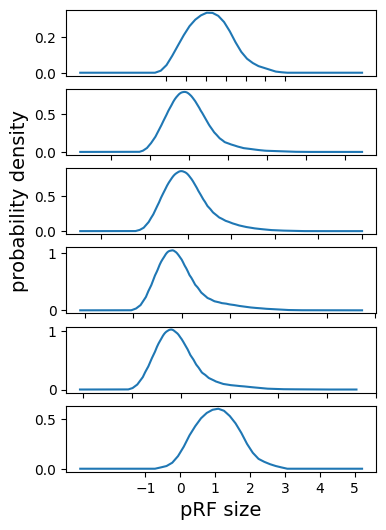

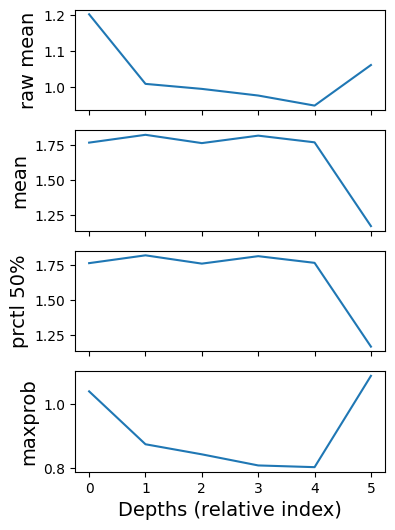

In [87]:
pRFsizes = V3_all_sigma_list
prctl = 50
kernel = "epa"    # "gau", biw", "cos", "epa", "triw"
bw = "scott"  # "scott", "normal_reference", "silverman"
adj = 6

sigmas = np.zeros((len(depth),4))
score = ['raw mean','mean','prctl ' + str(prctl) + '%','maxprob']
#good_idx = [0,1,2,4,5,6,7]

# CI array init
V3_CI_lower = np.zeros([n_depth,])
V3_CI_upper = np.zeros([n_depth,])
V3_SE = np.zeros([n_depth,])
V3_SD = np.zeros([n_depth,])
V3_HDI = np.zeros([n_depth,2])

fig, ax = plt.subplots(nrows=len(depth), ncols=1,figsize=(4, 6))
for n in range(0,len(depth)):
    X = pRFsizes[n]
    dens = sm.nonparametric.KDEUnivariate(X)
    dens.fit(fft=False,kernel=kernel,bw=bw,adjust=adj) 
    ax[n].plot(dens.support,dens.density)
    ax[n].set_xticks(np.arange(-1,6))
    if n != len(depth)-1 :
        ax[n].set_xticklabels([])
    s = dens.support
    idx = np.argmax(dens.density)
    #print(s[idx])
    sigmas[n,0] = np.mean(X)
    sigmas[n,1] = np.mean(dens.support)
    sigmas[n,2] = np.percentile(dens.support,prctl)
    sigmas[n,3] = s[idx]
    
    # get 95% HDI (high density interval)
    data = np.array(X)
    data = data[np.isfinite(data)]
    
    density = dens.density
    kde = gaussian_kde(data)
    
    # Evaluate the density function at a range of values
    x = np.linspace(s.min(), s.max(), 1000)
    pdf = kde(x)
    
    # Find the 95% HDI
    q = 0.95
    cdf = np.cumsum(pdf) / np.sum(pdf)
    idx1 = np.argmin(np.abs(cdf - (1 - q) / 2))
    idx2 = np.argmin(np.abs(cdf - (1 + q) / 2))
    V3_HDI[n,:] = [x[idx1], x[idx2]]
    
    # get bootstrapped CI's
    V3_CI_lower[n] = np.percentile(V3_maxprobs[n,:], 2.5)
    V3_CI_upper[n] = np.percentile(V3_maxprobs[n,:], 97.5)
    V3_SE[n] = np.std(V3_maxprobs[n,:], ddof=1) / np.sqrt(n_boot)
    V3_SD[n] = np.std(V3_maxprobs[n,:], ddof=1) 
    
ax[2].set_ylabel('probability density', fontsize=14)
ax[5].set_xlabel('pRF size', fontsize=14)


fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(4, 6))
for n in range(4):
    ax[n].plot(sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)

V3_sigmas=sigmas

Text(0.5, 0, 'Depths (relative index)')

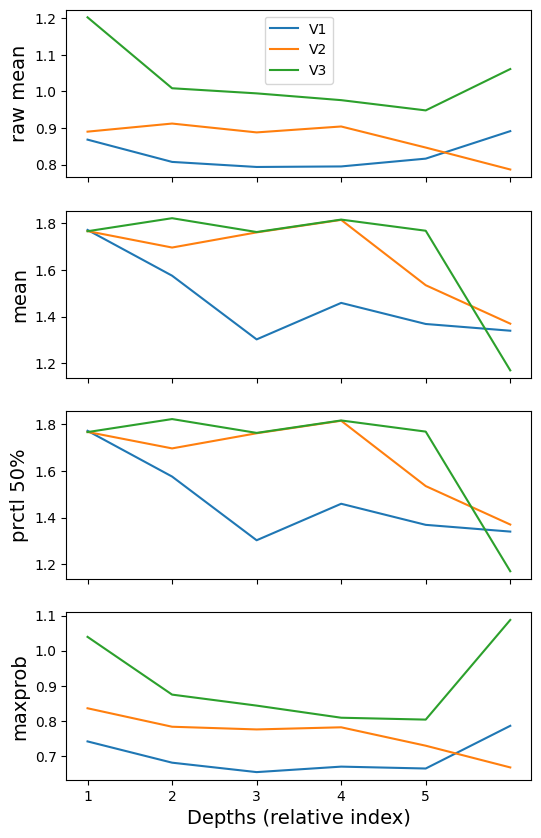

In [88]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(6, 10))
for n in range(4):
    ax[n].plot(V1_sigmas[:,n])
    ax[n].plot(V2_sigmas[:,n])
    ax[n].plot(V3_sigmas[:,n])
    ax[n].set_ylabel(score[n], rotation=90, fontsize=14)
    if n !=3 :
        ax[n].set_xticklabels([])
    else:
        ax[n].set_xticks([0,1,2,3,4])
        ax[n].set_xticklabels([1,2,3,4,5])
    if n == 0 :
        ax[n].legend(['V1','V2','V3'])
ax[3].set_xlabel('Depths (relative index)', fontsize=14)


In [89]:
V3_HDI

array([[0.01929824, 3.05654892],
       [0.32470204, 2.30401127],
       [0.36169449, 2.26642082],
       [0.36281458, 2.30222857],
       [0.35515163, 2.19571381],
       [0.22777385, 2.07968333]])

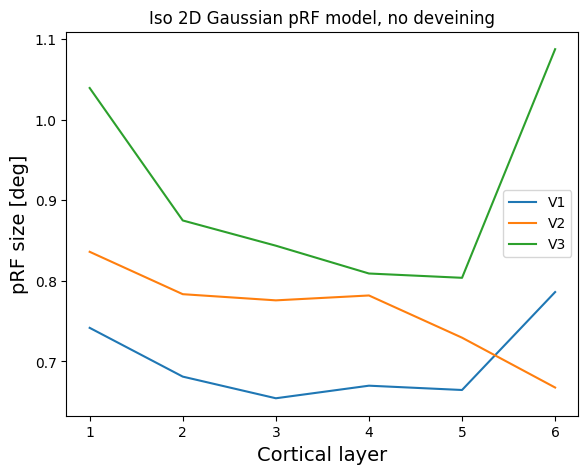

In [90]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes

start_depth = 0
n = 3 #only plot max prob
use_cortdist=False
errorbar='none' #'SE', 'SD', 'CI', 'HDI'
if errorbar=='SE':
    nr_ses = 3 # nr of standard errors of the mean
elif errorbar=='SD':
    nr_sds = 1 # nr of standard deviations of the mean
    
# get list of cortical layers
if start_depth==1:
    x_allROI = np.arange(0,len(depth)-1)
else:
    x_allROI = np.arange(0,len(depth))

if use_cortdist:
    # get cortical distances in mm for each ROI
    x_V1 = np.zeros([n_depth,])
    x_V2 = np.zeros([n_depth,])
    x_V3 = np.zeros([n_depth,])
    for n in range(0,len(depth)):
        x_V1[n] = np.mean(V1_cortdist_list[n])
        x_V2[n] = np.mean(V2_cortdist_list[n])
        x_V3[n] = np.mean(V3_cortdist_list[n])
else:
    x_V1, x_V2, x_V3 = x_allROI, x_allROI, x_allROI

#V1
hndl1,=ax.plot(x_V1,V1_sigmas[start_depth:,3])
if errorbar=='CI':
    ax.fill_between(x_V1, V1_CI_lower[start_depth:,], V1_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax.fill_between(x_V1, V1_sigmas[start_depth:,3]-nr_ses*V1_SE[start_depth:,], V1_sigmas[start_depth:,3]+nr_ses*V1_SE[start_depth:,],alpha=0.5)
elif errorbar=='SD':
    ax.fill_between(x_V1, V1_sigmas[start_depth:,3]-nr_sds*V1_SD[start_depth:,], V1_sigmas[start_depth:,3]+nr_sds*V1_SD[start_depth:,],alpha=0.5)
elif errorbar=='HDI':
    ax.fill_between(x_V1, V1_HDI[start_depth:,0], V1_HDI[start_depth:,1],alpha=0.5)

#V2
hndl2,=ax.plot(x_V2,V2_sigmas[start_depth:,3])
if errorbar=='CI':
    ax.fill_between(x_V2, V2_CI_lower[start_depth:,], V2_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax.fill_between(x_V2, V2_sigmas[start_depth:,3]-nr_ses*V2_SE[start_depth:,], V2_sigmas[start_depth:,3]+nr_ses*V2_SE[start_depth:,],alpha=0.5)
elif errorbar=='SD':
    ax.fill_between(x_V2, V2_sigmas[start_depth:,3]-nr_sds*V2_SD[start_depth:,], V2_sigmas[start_depth:,3]+nr_sds*V2_SD[start_depth:,],alpha=0.5)
elif errorbar=='HDI':
    ax.fill_between(x_V2, V2_HDI[start_depth:,0], V2_HDI[start_depth:,1],alpha=0.5)

#V3
hndl3,=ax.plot(x_V3,V3_sigmas[start_depth:,3])
if errorbar=='CI':
    ax.fill_between(x_V3, V3_CI_lower[start_depth:,], V3_CI_upper[start_depth:,],alpha=0.5)
elif errorbar=='SE':
    ax.fill_between(x_V3, V3_sigmas[start_depth:,3]-nr_ses*V3_SE[start_depth:,], V3_sigmas[start_depth:,3]+nr_ses*V3_SE[start_depth:,],alpha=0.5)
elif errorbar=='SD':
    ax.fill_between(x_V3, V3_sigmas[start_depth:,3]-nr_sds*V3_SD[start_depth:,], V3_sigmas[start_depth:,3]+nr_sds*V3_SD[start_depth:,],alpha=0.5)
elif errorbar=='HDI':
    ax.fill_between(x_V3, V3_HDI[start_depth:,0], V3_HDI[start_depth:,1],alpha=0.5)

# add xticks and labels
if use_cortdist:
    n_ticks=8
    ax.set_xticks(np.linspace(round(np.min(np.concatenate([x_V1,x_V2,x_V3])),1),
            round(np.max(np.concatenate([x_V1,x_V2,x_V3])),1),n_ticks))
    ax.set_xlabel('Cortical depth [mm]', fontsize=14)
else:
    ax.set_xlabel('Cortical layer', fontsize=14)
    if start_depth==1:
        ax.set_xticks(np.arange(0,len(depth)-1))
        ax.set_xticklabels(np.arange(1,len(depth)))
    elif start_depth==0:
        ax.set_xticks(np.arange(0,len(depth)))
        ax.set_xticklabels(np.arange(1,len(depth)+1))

# add ylabel, title, legend
ax.set_ylabel('pRF size [deg]', rotation=90, fontsize=14)
ax.legend([hndl1,hndl2,hndl3],['V1','V2','V3'])
if prf_model=='prfpy_Iso2DGaussianModel_LinearDeveining':
    ax.set_title('Iso-2D Gaussian pRF model, linear deveining')
elif prf_model=='prfpy_Iso2DGaussianModel':
    ax.set_title('Iso 2D Gaussian pRF model, no deveining')


In [101]:
for n in range(0,len(V2_all_sigma_list)):
    print(len(V1_cortdist_list[n]))

83
1401
2093
2527
1703
88


In [92]:
# x_V1 = np.zeros([n_depth,])
# x_V2 = np.zeros([n_depth,])
# x_V3 = np.zeros([n_depth,])
# for n in range(0,len(depth)):
#     x_V1[n] = np.mean(V1_cortdist_list[n])
#     x_V2[n] = np.mean(V2_cortdist_list[n])
#     x_V3[n] = np.mean(V3_cortdist_list[n])

In [93]:
sub_id=0
hem_id=0

In [94]:
# prfpy_dir    = '/home/mayajas/scratch/project-00-7t-pipeline-dev/output/'+prf_model+'/'+subject_list[sub_id]
# proj_dir     = '/home/mayajas/scratch/project-00-7t-pipeline-dev/'
# data_dir     = opj(proj_dir,'output','func','sliceTimeCorr',
#                 '_subject_id_'+subject_list[sub_id])
# ROI_dir      = opj(prfpy_dir,'ROIs')
# if layer_space == 'func':
#     lay_dir      = opj(prfpy_dir,'layerification_func')
# else:
#     lay_dir      = opj(prfpy_dir,'layerification')
# lay_dir_func     = opj(prfpy_dir,'layerification_func')

# # image files
# meanFunc_fn  = opj(prfpy_dir,'meanFunc.nii')
# UNI_func_fn  = opj(prfpy_dir,'UNI_funcSpace.nii')

# GM_fn        = opj(prfpy_dir,
#                 hem_list[hem_id]+'_GM_funcSpace.nii')
# occ_fn       = opj(prfpy_dir,
#                 'funcSpaceOccipitalMask.nii')
# bar1_fn      = opj(data_dir,'_sess_id_task-bar_run-01_sess_nr_0_sess_nvol_124','atask-bar_run-01_roi_warp4D.nii')
# bar2_fn      = opj(data_dir,'_sess_id_task-bar_run-02_sess_nr_1_sess_nvol_124','atask-bar_run-02_roi_warp4D.nii')


# # prfpy output files
# grid_fit_fn      = opj(prfpy_dir,hem_list[hem_id]+'_grid_fit.pckl')
# iterative_fit_fn = opj(prfpy_dir,hem_list[hem_id]+'_iterative_fit.pckl')
# pRF_param_fn     = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params.pckl')
# equivol_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equivol.pckl')
# equidist_param_fn = opj(prfpy_dir,hem_list[hem_id]+'_pRF_params_equidist.pckl')


# # manual ROI delineations
# V1_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V1.nii')
# V2_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V2.nii')
# V3_fn        = opj(ROI_dir,'func_'+hem_list[hem_id]+'_V3.nii')
# ecc2_fn      = opj(ROI_dir,'func_'+hem_list[hem_id]+'_ecc2.nii')

# # layers
# lay_equidist_fn = opj(lay_dir,'func_ribbon_rim_layers_equidist.nii')
# lay_equivol_fn = opj(lay_dir,'func_ribbon_rim_layers_equivol.nii')

# # cortical distances (mm)
# cortdist_fn = opj(lay_dir_func,'cortical_distances.nii')

In [95]:
# ###########################################################################################
# ## Load image files
# occ = nib.load(occ_fn)
# GM = nib.load(GM_fn)
# meanFunc = nib.load(meanFunc_fn)
# UNI = nib.load(UNI_func_fn)

# V1=nib.load(V1_fn)
# V2=nib.load(V2_fn)
# V3=nib.load(V3_fn)

# ecc2=nib.load(ecc2_fn)

# lay_equidist=nib.load(lay_equidist_fn)
# lay_equivol=nib.load(lay_equivol_fn)
# cort_distances=nib.load(cortdist_fn)


# # define mask (GM+occipital) and process bar data and masker
# mask = image.math_img("np.logical_and(img1, img2)", img1=occ, img2=GM)
# masker = NiftiMasker(mask_img=mask)

# # mask input files
# masked_meanFunc = masker.fit_transform(meanFunc)
# masked_meanFunc = np.squeeze(masked_meanFunc)

# masked_V1 = masker.fit_transform(V1)
# masked_V1 = np.squeeze(masked_V1)

# masked_V2 = masker.fit_transform(V2)
# masked_V2 = np.squeeze(masked_V2)

# masked_V3 = masker.fit_transform(V3)
# masked_V3 = np.squeeze(masked_V3)

# masked_ecc2 = masker.fit_transform(ecc2)
# masked_ecc2 = np.squeeze(masked_ecc2)

# masked_lay_equidist = masker.fit_transform(lay_equidist)
# masked_lay_equidist = np.squeeze(masked_lay_equidist)

# masked_lay_equivol = masker.fit_transform(lay_equivol)
# masked_lay_equivol = np.squeeze(masked_lay_equivol)

# masked_cort_distances = masker.fit_transform(cort_distances)
# masked_cort_distances = np.squeeze(masked_cort_distances)

In [96]:
# ###########################################################################################
# ## Load pRF results
# f = open(pRF_param_fn,'rb')
# x, y, sigma, total_rsq, polar, ecc = pickle.load(f)
# f.close()

In [97]:
# layers
# for layer in range(int(min(np.unique(masked_lay_equivol))),int(max(np.unique(masked_lay_equivol)))):
#     print(layer)

In [98]:
# np.unique(masked_lay_equivol)

In [99]:
# layers     = np.arange(1,n_layers+1)
# layers